<a href="https://colab.research.google.com/github/z4n0/TESI/blob/main/MIP_classifier_Official.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN MIP CLASSIFIER


In [ ]:
%load_ext autoreload
%autoreload 2
import platform
import os

gdrive = False
linux = True 
# Detect if we're running on a Linux system
linux = platform.system() == "Linux"

# Detect if we're in a Google Colab environment by attempting to import google.colab
try:
    from google.colab import drive
# Mount Google Drive
    drive.mount('/content/drive')
    gdrive=True
except ImportError:
    gdrive = False

# Detect if we're in a Kaggle environment by checking for a Kaggle-specific environment variable
kaggle = "KAGGLE_URL_BASE" in os.environ

environment_flags = {'kaggle': kaggle, 'gdrive': gdrive, 'linux': linux}
print("Environment settings:", environment_flags)

## install requirements

## IMPORTS

In [2]:
import os
import tifffile
import glob
import random
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import numpy as np
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.model_selection import StratifiedKFold
from monai.data import Dataset, DataLoader
# from classes.PrintShapeTransform import PrintShapeTransform
from monai.utils.misc import set_determinism
import monai
print(monai.__version__)
#import tifffile
#from monai.networks.nets import DenseNet121
import torch.nn.functional as F
from monai.visualize import GradCAMpp,GradCAM  
#kaggle = input("Are you on Kaggle? Enter 'T' for True or 'F' for False: ")
kaggle = False
if gdrive:
    import os

    # Change to the desired directory:
    os.chdir('/content/drive/MyDrive/TESI/TESI/notebooks')

    # Verify the current directory:
    print(os.getcwd())

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
    
from utils.reproducibility_functions import set_global_seed
set_global_seed(42)

2.6.0+cu124
1.4.0


## PARAMETERS THAT WILL GET LOGGED ON MLFLOW

In [3]:
import sys
# Add the parent directory to Python path to make configs package accessible
from configs.ConfigLoader import ConfigLoader
sys.path.append(os.path.dirname(os.getcwd()))

yaml_path = "/home/zano/Documents/TESI/TESI/configs/4c/base.yaml"
colab_yaml_path = "/content/drive/MyDrive/TESI/TESI/configs/base.yaml"
try:
    cfg = ConfigLoader(yaml_path)
except ValueError as e:
    print(f"Error loading configuration: {e}")
    print("Please ensure the YAML file contains all required sections.")
    raise

# Set a fixed random seed for reproducibility for all the soruces of randomness
# python, numpy, torch, monai
SEED = 42
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
set_determinism(seed=SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
import torch.backends.cudnn as cudnn
cudnn.deterministic = True   # forces deterministic convolution algorithms
cudnn.benchmark     = False  # turn off data-dependent autotune
# monai.utils.set_determinism(seed=SEED)

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/4c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.5, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 4, 'out_channels': 2, 'dropout_prob': 0.1, 'patch_size': [32, 32]}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': False, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceL

# UNIFIED DATA SELECTION

In [40]:
from utils.directory_functions import get_data_directory, get_base_directory
num_input_channels = int(input("Enter the number of input channels (3 or 4): "))

data_dir = get_data_directory(kaggle, gdrive,linux, num_input_channels=num_input_channels)
print("data dir:",data_dir)
base_dir = get_base_directory(kaggle, gdrive, linux)
print("base_dir:",base_dir)
# start mlflow ui
from utils.mlflow_functions import *
from utils.directory_functions import *

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
start_mlflow_ui(tracking_uri) # start mlflow ui

3 channels input
you are in linux
/home/zano/Documents/TESI/3c_MIP_new
data dir: /home/zano/Documents/TESI/3c_MIP_new
base_dir: /home/zano/Documents/TESI/TESI
you are on linux
Linux detected, setting tracking URI
Final Tracking URI: /home/zano/Documents/TESI/mlruns
Does the directory exist? True


In [41]:
import ipywidgets as widgets
from IPython.display import display

CLASS_NAME_SETS = {
    "MSA vs Control": ["MSA", "control"],
    "MSA vs PD": ["MSA", "PD"],
    "MSA-P vs MSA-C": ["MSA-P", "MSA-C"],
    "MSA-P vs PD": ["MSA-P", "PD"],
    "PD vs MSA-P vs MSA-C": ["PD", "MSA-P", "MSA-C"]
}

dropdown = widgets.Dropdown(
    options=list(CLASS_NAME_SETS.keys()),
    value="MSA vs PD",
    description='Class Set:',
    style={'description_width': 'initial'}
)

def on_dropdown_change(change):
    """
    Update the class_names variable when the dropdown selection changes.
    """
    global class_names
    if change['type'] == 'change' and change['name'] == 'value':
        class_names = CLASS_NAME_SETS[change['new']]
        print(f"class_names set to: {class_names}")


class_names = CLASS_NAME_SETS[dropdown.value]

dropdown.observe(on_dropdown_change)

display(dropdown)

Dropdown(description='Class Set:', index=1, options=('MSA vs Control', 'MSA vs PD', 'MSA-P vs MSA-C', 'MSA-P v…

In [42]:
print(f"class_names set to: {class_names}") #chekc if the class names are set correctly

class_names set to: ['MSA-P', 'PD']


# DATA EXTRACTION

In [ ]:
# Create a dictionary mapping each class to its directory
class_dirs = {}
three_classes = (len(class_names) == 3)

for class_name in class_names:
    class_dirs[class_name] = os.path.join(data_dir, class_name)
    
print(class_dirs)
if three_classes:
    class2_name, class1_name, class0_name = class_names
    class2_dir, class1_dir, class0_dir = class_dirs.values()
else:
    class1_name, class0_name = class_names
    class1_dir, class0_dir = class_dirs.values()

print("Class directories:")
print(class_dirs)

# Dictionaries to store image paths and counts for each class
images_paths_dict = {}
counts_dict = {}

# Loop over classes to process each folder
for class_name in class_names:
    class_dir = class_dirs[class_name]
    image_paths = sorted(glob.glob(os.path.join(class_dir, "*.tif")))
    
    # Check if images were found; otherwise raise an error
    if not image_paths:
        raise FileNotFoundError(f"No TIFF image file found in {class_dir}")
    
    # Count occurrences of 'gh' and 'vaso' in the filenames (using .lower() for case insensitivity)
    gh_count = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"{class_name} images (before filtering): 'gh' count: {gh_count}, 'vaso' count: {vaso_count}")
    
    # Filter out images that contain 'vaso' (if needed)
    image_paths = [path for path in image_paths if 'vaso' not in os.path.basename(path).lower()]
    gh_count_after = sum('gh' in os.path.basename(path).lower() for path in image_paths)
    vaso_count_after = sum('vaso' in os.path.basename(path).lower() for path in image_paths)
    print(f"After removing 'vaso', {class_name} images: 'gh' count: {gh_count_after}, 'vaso' count: {vaso_count_after}")
    
    # Store the filtered image paths and counts for later use
    images_paths_dict[class_name] = image_paths
    counts_dict[class_name] = {"gh_count": gh_count_after, "vaso_count": vaso_count_after}

# Visualize the number of 'gh' counts per class in a bar chart
plt.figure()
plt.xlabel("Class")
plt.ylabel("Number of 'gh' occurrences")
plt.title("Number of 'gh' occurrences per class")
bar_heights = [counts_dict[cn]["gh_count"] for cn in class_names]
bar_colors = ['red', 'blue', 'lightblue']
plt.bar(class_names, bar_heights, color=bar_colors)
plt.show()

# --- Debug: Check image shapes after initial loading ---
print("\nChecking image shapes:")
for class_name, image_paths in images_paths_dict.items():
    for path in image_paths:
        img = tifffile.imread(path)  # Read image as a numpy array
        print(f"{class_name} image: {os.path.basename(path)}  dtype: {img.dtype}, shape: {img.shape}")

# Combine image paths and labels for the three classes; 
# the label here is simply the index of the class in class_names (0, 1, 2)
combined = [] # List to store tuples of (image_path, label)
for label, class_name in enumerate(class_names):
    for path in images_paths_dict[class_name]:
        combined.append((path, label))
# print("\nSample of combined image paths and labels:", combined[:5])
random.shuffle(combined)  # Shuffle the combined list to mix classes

# Optionally, determine the minority label for resampling purposes
counts = {label: len(images_paths_dict[class_name]) for label, class_name in enumerate(class_names)}
minority_label = min(counts, key=counts.get)
print(f"\nMinority label for resampling purposes: {minority_label}")

# Unzip the combined list back into separate tuples (if needed)
images_paths, labels = zip(*combined)
print("\nSample of image paths:", images_paths[:5])
print("Total images found:", len(combined))

# Optionally, convert to NumPy arrays (helpful for further processing or k-fold splitting)
images_paths_np = np.array(images_paths)
labels_np = np.array(labels)
print("\nSample of image paths (NumPy):", images_paths_np[:5])
print((labels_np))
#print(X)

## TEST SET SPLIT

In [ ]:
# NB the test set must be splitted BEFORE oversampling to avoid data leakage!
# -------------------------------------------------------------------------
#from sklearn.model_selection import train_test_split
#returns numpy arrays containing the paths to images and the labels
# print(cfg.data_splitting["random_seed"])
train_images_paths, test_images_paths, train_true_labels, test_true_labels = train_test_split(
    images_paths_np,
    labels_np,
    test_size = cfg.data_splitting["test_set_size"],
    stratify=labels,
    random_state=42
)

test_images_paths_np = np.array(test_images_paths)
test_true_labels_np = np.array(test_true_labels)
print("train images paths:", train_images_paths)
print("true test labels:", test_true_labels)
# # For the cross-validation, we'll use train_images_paths and labels_temp
train_images_paths_np = np.array(train_images_paths) #contains the images paths
train_labels_np = np.array(train_true_labels) #contains the labels
print(f"{train_images_paths_np.shape[0]} training images")
print(f"{len(test_images_paths)} test images")
#test_images_paths = [os.path.basename(path) for path in test_images_paths]
print(test_images_paths)
print(type(train_images_paths))

# TEST SPLIT AND DATA VISUALIZATION

In [ ]:
from utils.data_visualization_functions import visualize_and_compare_pixel_intensity_histograms

# Example Usage (assuming you have images_balanced_paths and labels_balanced defined):
visualize_and_compare_pixel_intensity_histograms(images_paths_np, labels_np, class1_name, class0_name)
print("test images intenisty distribution")
print("test images labels:", test_true_labels_np)
visualize_and_compare_pixel_intensity_histograms(test_images_paths_np, test_true_labels_np, class1_name, class0_name)

We can see that MSA classes are much darker than control classes. we need some augmentation to avoid the model to learn to disambiguate classes using darker regions in the image.
Augmentation which does this are:


1.   Min-Max Scaling
2.   Normalization (x channel or not)
3.   RandAdjustContrastd
4.   RandHistogramShiftd
5.   Histogram Matching

Batch normalization (already implemented in the nets) also can help the cnn to be indifferent to such thing

## TEST SET VISUALIZATIONS

In [ ]:
from utils.data_visualization_functions import visualize_tiff
# Example usage:
for i in range(len(test_images_paths)):
    print(f" Image{i} : {test_images_paths[i]}")
    visualize_tiff(test_images_paths[i], channel_wise_norm=False)

# TRAINING

## AUGMENTATIONS


### VISUALIZING THE EFFECTS OF TRANSFORMATIONS

In [ ]:
from utils.transformations_functions import get_transforms
from configs.ConfigLoader import ConfigLoader

#from configs.Config_loader import Config_loader  # Corrected import
yaml_path =  f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/resnet18.yaml"
cfg = ConfigLoader(yaml_path)  # Corrected usage
#cfg = Config_loader(yaml_path) #Corrected usage
cfg.set_freezed_layer_index(None)
train_transforms, val_transforms, test_transforms = get_transforms(cfg)

Configuration loaded from /home/zano/Documents/TESI/TESI/configs/3c/base.yaml
Configuration: {'data_splitting': {'random_seed': 42, 'val_set_size': 0.2, 'test_set_size': 0.1, 'num_folds': 6}, 'data_augmentation': {'resize_spatial_size': [256, 256], 'rand_flip_prob': 0.3, 'rand_flip_spatial_axes': [0, 1], 'rand_rotate90_prob': 0.3, 'rand_rotate90_max_k': 3, 'rand_gaussian_noise_prob': 0.4, 'rand_gaussian_noise_mean': 0.0, 'rand_gaussian_noise_std': 0.1}, 'data_loading': {'batch_size': 8, 'num_workers': 0}, 'model': {'model_name': 'base', 'spatial_dims': 2, 'in_channels': 3, 'out_channels': 2, 'dropout_prob': 0.1}, 'training': {'num_epochs': 50, 'early_stopping_patience': 17, 'mixup_alpha': 0, 'oversample': True, 'undersample': False, 'weighted_loss': False, 'fine_tuning': False, 'transfer_learning': True, 'freezed_layerIndex': None}, 'optimizer': {'learning_rate': '1e-4', 'optimizer_name': 'Adam', 'weight_decay': '2e-5'}, 'scheduler': {'scheduler_name': 'ReduceLROnPlateau', 'factor': 0.

In [ ]:
from classes.CustomTiffFileReader import CustomTiffFileReader
from utils.data_visualization_functions import visualize_dict_image, visualize_and_compare_pixel_intensity_histograms, calculate_tensor_histogram, min_max_normalization
from monai.transforms import Compose
from utils.transformations_functions import from_GBR_to_RGB
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Resized,
    ScaleIntensityd,
    NormalizeIntensityd,
    RandFlipd,
    RandRotate90d,
    RandGaussianNoised,
    RandRotated,
    RandAdjustContrastd,
    RandBiasFieldd,  # Simulates a smooth, spatially varying intensity bias field (common in microscopy due to uneven illumination). Highly recommended.
    EnsureTyped,
    RandSpatialCropd,
    LambdaD,
    RandHistogramShiftd,
    DataStatsd,  # Computes statistics (min, max, mean, std) of the image intensities.
    AddCoordinateChannelsd,  # Adds channels representing spatial coordinates; can sometimes help CNNs learn spatial relationships.
    RandCoarseDropoutd,
    CenterSpatialCropd,
    Rand2DElasticd,
    RandGridPatchd,
    ClipIntensityPercentilesd,  # Clip intensities at specified low and high percentiles to remove extreme outlier pixels.
    HistogramNormalized,  # Standardizes image histograms, can be useful if illumination/staining varies significantly.
)
# Helper function to visualize
normalization_params = {
        "subtrahend": [0.485, 0.456, 0.406],
        "divisor": [0.229, 0.224, 0.225],
    } if cfg.training["pretrained"] else {
        "subtrahend": None,
        "divisor": None,
    }

# Flag to control inclusion of color/intensity transforms
use_color_transforms = True  # Set to False to exclude color transforms

# Build the composite transform as a single list, with color transforms appended if enabled
train_transforms_list = [
    CustomTiffFileReader(keys=["image"]),
    EnsureTyped(keys=["image"], data_type="tensor", dtype=torch.float32),
    LambdaD(keys="image", func=from_GBR_to_RGB),
    Resized(
        keys="image",
        spatial_size=(256,256),
        mode='bilinear',
        size_mode='all'
    ),
    # Core Spatial Augmentations (applied before cropping/patching)
    RandFlipd(
        keys="image",
        prob=1,
        spatial_axis=cfg.data_augmentation.get("rand_flip_spatial_axes", [0, 1])[0]
    ),
    RandFlipd(
        keys="image",
        prob=1,
        spatial_axis=cfg.data_augmentation.get("rand_flip_spatial_axes", [0, 1])[1]
    ),
    RandRotate90d(
        keys="image",
        prob=1,
        max_k=cfg.data_augmentation.get("rand_rotate90_max_k", 3)
    ),
    # RandAffined(
    #     keys="image",
    #     prob=1,
    #     rotate_range=cfg.data_augmentation.get(
    #         "rand_affine_rotate_range", ((-np.pi/12), np.pi/12)
    #     ),
    #     scale_range=cfg.data_augmentation.get(
    #         "rand_affine_scale_range", (0.8, 1.2)
    #     ),
    #     shear_range=cfg.data_augmentation.get(
    #         "rand_affine_shear_range", ((-0.1), 0.1, (-0.1), 0.1)
    #     ),
    #     translate_range=cfg.data_augmentation.get(
    #         "rand_affine_translate_range", ((-10), 10, (-10), 10)
    #     ),
    #     mode='bilinear',
    #     padding_mode='border'
    # ),
    Rand2DElasticd(
        keys=["image"],
        spacing=cfg.data_augmentation.get("rand_2d_elastic_spacing", (30, 30)), # Spacing for the grid control points
        magnitude_range=cfg.data_augmentation.get("rand_2d_elastic_magnitude", (0.2, 1.5)), # Magnitude of the elastic deformation 
        prob=1,
        rotate_range=cfg.data_augmentation.get("rand_2d_elastic_rotate_range", (np.pi / 12)), # rotation range between -pi/12 and pi/12
        scale_range=cfg.data_augmentation.get("rand_2d_elastic_scale_range", (0.9, 1.1)), #zoom range between 90% and 110%
        mode='bilinear',
        padding_mode='border',
    ),
    # Patching Strategy
    RandSpatialCropd(
        keys="image",
        roi_size=cfg.data_augmentation.get("crop_size", (224, 224)),
        random_size=False
    ),
    # Intensity Preprocessing & Augmentations (applied per patch)
    ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
    NormalizeIntensityd(
                    keys=["image"],
                    # subtrahend=None,
                    # divisor=torch.tensor(fold_specific_stats["std"]),
                    channel_wise=True
                )
]

# Add base intensity augmentations (noise)
train_transforms_list.append(
    RandGaussianNoised(
        keys="image",
        prob=1,
        mean=cfg.data_augmentation.get("rand_gaussian_noise_mean", 0.0),
        std=cfg.data_augmentation.get("rand_gaussian_noise_std", 0.1)
    )
)

# Conditionally add other color/intensity transforms
if use_color_transforms:
    train_transforms_list.extend([
        RandHistogramShiftd(
            keys=["image"],
            prob=1,
            num_control_points=cfg.data_augmentation.get("rand_histogram_shift_num_control_points", 10)
        ),
        RandAdjustContrastd(
            keys=["image"],
            prob=1,
            gamma=cfg.data_augmentation.get("rand_adjust_contrast_gamma", (0.5, 1.5))
        ),
        RandBiasFieldd(
            keys=["image"],
            degree=cfg.data_augmentation.get("rand_bias_field_degree", 3),
            coeff_range=cfg.data_augmentation.get("rand_bias_field_coeff_range", (0.0, 0.2)),
            prob=1
        )
    ])

train_transforms = Compose(train_transforms_list)


In [ ]:
from utils.transformations_functions import get_transforms
train_transforms,_,_ = get_transforms(cfg, color_transforms=use_color_transforms)

In [ ]:
# Now you can call the visualization on the original images
print("Visualizing the image 3 channels histogram of the 2 classes before augmentations:")

visualize_and_compare_pixel_intensity_histograms(
    images_paths_np,  # original images
    test_true_labels,
    class1_name,
    class0_name
)

from classes.CustomTiffFileReader import CustomTiffFileReader
import tifffile

def get_tensor_img_from_dict(img_dict):
    img_path = img_dict["image"]
    img_np = tifffile.imread(img_path)  # Read the image as a numpy array
    img_tensor = torch.tensor(img_np, dtype=torch.float32)
    print(f"Image shape : {img_tensor.shape}, dtype: {img_tensor.dtype} device: {img_tensor.device}")
    
    if img_tensor.ndim > 3:
        raise ValueError(f"Image tensor has more than 3 dimensions: {img_tensor.ndim}. Expected 3D tensor (C, H, W).")

    return img_tensor

# Apply the transformations to the training images
def apply_transforms_to_images(images_paths_np, transforms):
    """ returns a list of transformed images as tensors"""
    transformed_images = []
    for path in images_paths_np:
        data_dict = {"image":path,"label":1}
        transformed_dict = transforms(data_dict) # in transforms there's the loading of the tensor

        img_tensor = transformed_dict["image"]
        if img_tensor.ndim > 3:
            raise ValueError(f"Image tensor has more than 3 dimensions: {img_tensor.ndim}. Expected 3D tensor (C, H, W).")

        transformed_images.append(img_tensor)

    return transformed_images

def channel_last(img_array:np.ndarray) -> np.ndarray:
    """Convert image array from (C, H, W) to (H, W, C) format."""
    if img_array.ndim == 3 and img_array.shape[0] in [3, 4]:  # Check if it's a 3-channel or 4-channel image
        return img_array.transpose(1, 2, 0)  # Transpose to (H, W, C)
    return img_array

# For the monai transforms that read from disk, you pass the path as
transformed_images_tensors_list = apply_transforms_to_images(images_paths_np, train_transforms)
transformed_images_np_list = []  # List to store numpy arrays of transformed images in format (H, W, C)
for img_tensor in transformed_images_tensors_list:
    image_array = img_tensor.cpu().numpy() #convert to numpy array
    # print(f"Transformed image shape: {image_array.shape}, dtype: {image_array.dtype}")

    # If needed, transpose from (C, H, W) -> (H, W, C)
    image_array = channel_last(image_array)
    # print(f"Transformed image shape after transpose: {image_array.shape}, dtype: {image_array.dtype}")
    transformed_images_np_list.append(image_array)

print("Visualizing the image 3 channels histogram of the 2 classes after augmentations:")

visualize_and_compare_pixel_intensity_histograms(
    transformed_images_np_list,
    test_true_labels,  # same labels for demonstration
    class1_name,
    class0_name
)

In [ ]:
# visualize transformations with dictionary transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import tifffile
import os
from monai.transforms import Compose
from classes.CustomTiffFileReader import CustomTiffFileReader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Resized, ScaleIntensityd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, RandGaussianNoised, EnsureTyped, LambdaD,
    RandHistogramShiftd, RandAdjustContrastd, RandCoarseDropoutd, CenterSpatialCropd,TorchVisiond,ToTensord
)
from monai.transforms import RandLambdad


from torchvision.transforms import ColorJitter, RandomGrayscale

# Helper function to visualize
normalization_params = {
        "subtrahend": [0.485, 0.456, 0.406],
        "divisor": [0.229, 0.224, 0.225],
    } if cfg.training["pretrained"] else {
        "subtrahend": None,
        "divisor": None,
    }
# Set your actual image path
image_path = images_paths_np[np.random.randint(0, len(images_paths_np))]
assert os.path.exists(image_path), f"File not found: {image_path}"

# Visualize step-by-step
intermediate_results = []
current_data = {"image": image_path, "label": 1} #dummy label

print("\n--- Applying dictionary transforms step-by-step ---")
for transform in train_transforms_list:
    name = transform.__class__.__name__
    # print(f"Applying: {name}")

    current_data = transform(current_data)

    # Handle MetaTensor or Tensor
    img_tensor = current_data["image"]
    # print(f"Output shape: {img_tensor.shape}, dtype: {img_tensor.dtype}")

    # Check if img_tensor is a PyTorch tensor and move to CPU if necessary
    if isinstance(img_tensor, torch.Tensor):
        # print("Converting to NumPy array...")
        img_np = img_tensor.cpu().numpy()
    else:
        # print("Not a PyTorch tensor, numpy array using as is...")
        img_np = img_tensor  # If it's already a NumPy array, use it directly
    intermediate_results.append((name, img_np.copy()))

def normalize_for_imshow(img_data):
    """
    Normalize image data for display with matplotlib's plt.imshow.

    This function assumes the input is either a uint8 NumPy array
    (raw image) or a float32 NumPy array (after transformation).
    - If uint8, returns as-is (imshow handles this natively).
    - If float32, min-max normalizes to [0, 1] for visualization.

    Parameters
    ----------
    img_data : np.ndarray
        The image data to normalize. Must be uint8 or float32.

    Returns
    -------
    np.ndarray or None
        The normalized image data as a NumPy array in the [0, 1] range,
        or the original array if dtype is uint8. Returns None if input is
        not a NumPy array or if the dtype is unsupported.
    """
    if not isinstance(img_data, np.ndarray):
        return None  # Only handle NumPy arrays

    if img_data.dtype == np.uint8:
        return img_data  # imshow handles uint8

    if img_data.dtype == np.float32:
        min_val, max_val = np.min(img_data), np.max(img_data)
        if max_val - min_val > 1e-6:
            img_data = (img_data - min_val) / (max_val - min_val)
        else:
            img_data = img_data - min_val  # Flat image, set to 0
        return np.clip(img_data, 0, 1)

    print(f"Warning: Unsupported dtype {img_data.dtype} for normalization.")
    return None

def plot_image_step(ax, data, title):
    """
    Plot a single transformation step's image on the provided Matplotlib Axes.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    data : np.ndarray
        The image data to plot.
    title : str
        The title for the subplot.
    """
    img_shape = getattr(data, 'shape', 'N/A')
    plot_title = f"{title}\nShape: {img_shape}"
    ax.set_title(plot_title, fontsize=10)
    ax.axis('off')

    img_to_show = None
    cmap = None

    if data.ndim == 2:  # Grayscale (H, W)
        img_to_show = normalize_for_imshow(data)
        cmap = 'gray'
    elif data.ndim == 3:
        if data.shape[0] == 1:  # Grayscale with channel (1, H, W)
            img_to_show = normalize_for_imshow(data[0, :, :])
            cmap = 'gray'
        elif data.shape[0] == 3:  # Color (3, H, W) -> (H, W, 3)
            transposed_img = np.transpose(data, (1, 2, 0))
            img_to_show = normalize_for_imshow(transposed_img)
        elif data.shape[0] == 4:  # Color with Alpha (4, H, W) -> (H, W, 3)
            transposed_img = np.transpose(data[:3, :, :], (1, 2, 0))
            img_to_show = normalize_for_imshow(transposed_img)

    if img_to_show is not None:
        ax.imshow(img_to_show, cmap=cmap)


num_steps = len(intermediate_results)
cols = 3
rows = (num_steps + cols - 1) // cols

plt.figure(figsize=(6 * cols, 5 * rows + 1)) # Adjust figsize as needed
plt.suptitle(f"Transformation Steps (Tifffile) for: {os.path.basename(image_path)}", fontsize=16)

for i, (title, img_data) in enumerate(intermediate_results):
    ax = plt.subplot(rows, cols, i + 1)
    plot_image_step(ax, img_data, title)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
plt.show()

In [ ]:
from utils.data_visualization_functions import display_images_by_class
# from utils.filtering_functions import filter_paths_by_imageIds, filter_paths_by_classIndex
class_names = class_names
display_images_by_class(images_paths_np, labels_np, class_names, ncols=5, normalize=True, overlay_alpha=0.2)

In [ ]:
from utils.data_visualization_functions import visualize_tiff
# for index,path in enumerate(images_paths_np):
#     print(f"Image: {path} index: {index}")
selected_index = 20 #image 5992
visualize_tiff(images_paths_np[selected_index],channel_wise_norm=True)

# UNSUPERVISED LEARNING

## FEATURE EXTRACTION AND PCA

here i define a Densenet121Feature extractor class which uses a densenet121 from monai, uses just the fen part of it to extract feature vector from the images and performs gap on the resulting feature maps so to obtained a single value for each feature map slice.

i then apply pca on the resulting features to further reduce dimensionality

we then proceed to use the resulting reduced features (on all images) to see if some meaningfull clusters can be detected

In [18]:
import torch
import torch.nn as nn
from monai.networks.nets import DenseNet121
from utils.mlflow_functions import get_tracking_uri, load_mlflow_model

class FeatureExtractorWrapper(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Extract intermediate convolutional features
        features = self.model.features(x) #keep only the fen features removing the last classification layer
        # Apply global average pooling to reduce the spatial dimensions.
        pooled = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        # Flatten to (B, C)
        feature_vector = pooled.view(pooled.size(0), -1)
        return feature_vector

# tracking_uri = get_tracking_uri(gdrive,kaggle,linux)  # Replace with your tracking URI
# experiment_name = f"{class0_name}_vs_{class1_name}_classifier"
# model = load_mlflow_model(tracking_uri, experiment_name, gdrive,kaggle,linux)

from utils.image_processing_functions import extract_images_features
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# Replace these with your actual file paths and labels.
image_paths = images_paths_np
true_labels = labels_np  

# ---------------------
# 4. Feature Extraction for All Images
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#choose the model eg DenseNet121, DenseNet169, DenseNet201, DenseNet264
model = DenseNet121(
    spatial_dims=2,
    in_channels=3,
    out_channels=2,
    pretrained=True,
).to(device)

feature_extractor = FeatureExtractorWrapper(model).to(device)

transforms = Compose([
    LoadImaged(keys="image", reader="ITKReader"), # Load the image from disk expects a file path in image
    EnsureChannelFirstd(keys="image", channel_dim=-1),
    LambdaD(keys="image", func=lambda x: x[:3, ...]),
    Resized(keys="image", spatial_size=cfg.data_augmentation["resize_spatial_size"]),
    ScaleIntensityd(keys="image"),  # Scale to [0.0, 1.0]
    ])

features_list = extract_images_features(image_paths, feature_extractor, transforms)

print("FINISHED FEATURE EXTRACTION")
print("feature shape:",features_list[0].shape)
print("total features:",len(features_list))

# ---------------------
# 5. Dimensionality Reduction with PCA
# ---------------------
pca = PCA(n_components=6) # Reduce the feature vector dimensionality to (N, n_components)
features_pca = pca.fit_transform(features_list)
print("Features shape after PCA:", features_pca.shape)

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 5

RuntimeError: applying transform <monai.transforms.io.dictionary.LoadImaged object at 0x7f0c04894980>

<Figure size 1000x400 with 0 Axes>

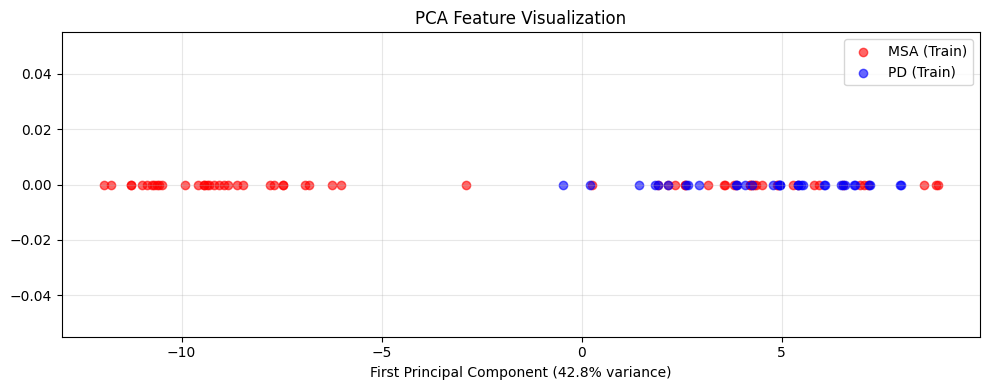

In [ ]:
plt.figure(figsize=(10, 4))

# Create 1D scatter plot using only first principal component
plt.figure(figsize=(10, 4))

# Create 1D scatter plot using only first principal component
plt.scatter(features_pca[labels_np == 1, 0], 
           np.zeros_like(features_pca[labels_np == 1, 0]),
           c='red', label=f'{class1_name} (Train)', alpha=0.6)

plt.scatter(features_pca[labels_np == 0, 0], 
           np.zeros_like(features_pca[labels_np == 0, 0]),
           c='blue', label=f'{class0_name} (Train)', alpha=0.6, marker='o')
# Add labels and title
plt.xlabel('First Principal Component')
plt.title('PCA Feature Visualization')
plt.legend()
plt.grid(True, alpha=0.3)

# Display explained variance ratio
variance_ratio = pca.explained_variance_ratio_
plt.xlabel(f'First Principal Component ({variance_ratio[0]:.1%} variance)')

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from monai.networks.nets import DenseNet121
from utils.mlflow_functions import get_tracking_uri, load_mlflow_model

# Define your feature extractor as before
class FeatureExtractorWrapper(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        # Extract intermediate convolutional features from your model.
        # This depends on the model's architecture. For MONAI's DenseNet121,
        # the features are available via `model.features(x)`.
        features = self.model.features(x)
        # Apply global average pooling to reduce the spatial dimensions.
        pooled = nn.functional.adaptive_avg_pool2d(features, (1, 1))
        # Flatten to (B, C)
        feature_vector = pooled.view(pooled.size(0), -1)
        return feature_vector

# Define your device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)  # Replace with your tracking URI
experiment_name = f"{class0_name}_vs_{class1_name}_classifier"
model = load_mlflow_model(tracking_uri, experiment_name, gdrive,kaggle,linux)

feature_extractor = FeatureExtractorWrapper(model).to(device)
features_list = extract_images_features(image_paths, feature_extractor, transforms)

you are on linux
Experiment 'PD_vs_MSA_classifier' has ID: 134221177559360481
Runs for experiment 'PD_vs_MSA_classifier':
  Run ID: 5094333d1eb24602870a460c2d3d17fd, Run Name: DenseNet121_oversamp_hyp_ALL_DS
  Run ID: 766fad79b2d24bd4a85650ccc549fa71, Run Name: DenseNet121_oversamp_hyp_ALL_DS
  Run ID: d011e2fdacb749528640b72da8d71fe2, Run Name: DenseNet121_oversamp_hyp_ALL_DS
  Run ID: e86f46585c7c4653ab8e20106f279e1f, Run Name: DenseNet121_oversamp_TL_pretrained_freeze263_HoldOut_hyp_NEWDS_TEST2
  Run ID: fadf7c1454c64440b5d5a9066dda20ca, Run Name: DenseNet121_oversamp_TL_pretrained_freeze263_HoldOut_hyp_NEWDS_TEST2
  Run ID: 3b31595bfe664c40a1a1ed82992c8768, Run Name: DenseNet121_oversamp_HoldOut_hyp_NEWDS_TEST2
  Run ID: 415f309ea0f2439896533062a280ee4c, Run Name: SimpleMONAICNN_oversamp_HoldOut_hyp_NEWDS_TEST2
  Run ID: 028a8b50e3e3481094fed00c72e1bac1, Run Name: SimpleMONAICNN_oversamp_HoldOut_hyp_NEWDS
  Run ID: 6e9914a5c3b342bab3a2a0b955ecb3c3, Run Name: DenseNet121_oversamp_TL

RuntimeError: Failed to load the model.

## T-SNE


## 2D t-sne

t-SNE result shape: (94, 2)


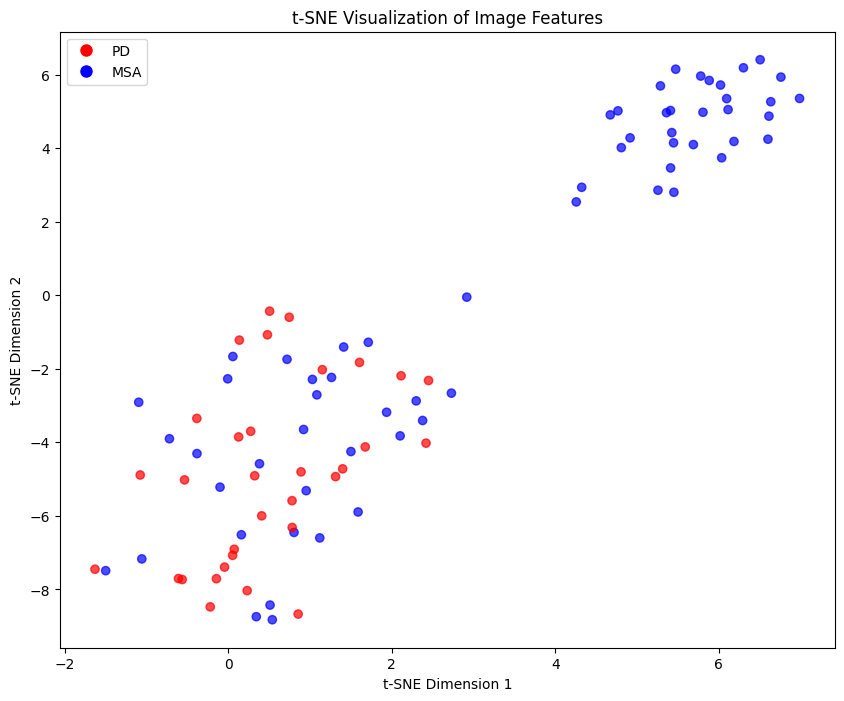

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=cfg.data_splitting["random_seed"])
features_tsne = tsne.fit_transform(features_pca)  # or features if skipping PCA
print("t-SNE result shape:", features_tsne.shape)

# Define color mapping
color_map = {0: 'red', 1: 'blue'}
true_point_colors = [color_map[label] for label in labels]

# Create figure and plot scatter
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=true_point_colors, alpha=0.7)

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=class0_name if label == 0 else class1_name,
                            markersize=10)
                  for label, color in color_map.items()]
plt.legend(handles=legend_elements)

plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

## 3D t-sne

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, max_iter=1000, random_state=cfg.data_splitting["random_seed"])
features_tsne = tsne.fit_transform(features_pca)  # or features if skipping PCA
print("t-SNE result shape:", features_tsne.shape)

t-SNE result shape: (94, 3)


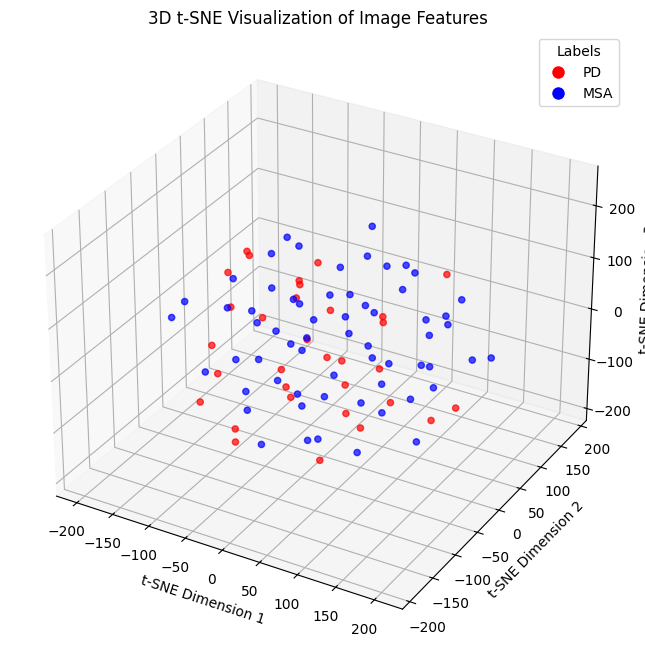

In [ ]:
# Suppose features_tsne is of shape (N, 3) and labels is an array of 0s and 1s.
# Define your custom colors for each label:
color_map = {0: 'red', 1: 'blue'}

# Map each label to its corresponding color.
true_point_colors = [color_map[label] for label in labels]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(features_tsne[:, 0],
                     features_tsne[:, 1],
                     features_tsne[:, 2],
                     c=true_point_colors,
                     alpha=0.7)

# Create custom legend handles.
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=color, label=class0_name if label == 0 else class1_name,
                            markersize=10)
                  for label, color in color_map.items()]
ax.legend(handles=legend_elements, title="Labels")
# 
ax.set_title("3D t-SNE Visualization of Image Features")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3")
plt.show()

## INTERACTIVE 3D t-sne

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
from utils.data_visualization_functions import visualize_tiff

# Create a DataFrame that holds your metadata.
df = pd.DataFrame({
    'x': features_tsne[:, 0],
    'y': features_tsne[:, 1],
    'z': features_tsne[:, 2],
    'label': labels,
    'image_path': image_paths,  # full paths or names for your images
})

# Define a discrete color mapping for your classes.
color_map = {0: 'red', 1: 'blue'}
true_point_colors = [color_map[label] for label in df['label']]

# Create an interactive 3D scatter plot using Plotly FigureWidget.
fig = go.FigureWidget(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=5,
        color=true_point_colors  # manually assign colors for discrete labels
    ),
    # Save the image path in customdata to access in the callback.
    customdata=df['image_path'],
    # Set a hovertemplate to show the image path on hover.
    hovertemplate="Image: %{customdata}<extra></extra>"
)])
fig.update_layout(
    title='Interactive 3D t-SNE Visualization',
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    width=1000,  # Set the width (in pixels)
    height=1000
)

# Create an Output widget to display messages and images.
output = widgets.Output()
display(output)

# Define the click callback function using the Output widget.
def click_fn(trace, points, state):
    if points.point_inds:
        idx = points.point_inds[0]
        image_path = trace.customdata[idx]
        with output:
            output.clear_output(wait=True)
            print("Clicked on image:", image_path)
            try:
                visualize_tiff(image_path)
            except Exception as e:
                print("Error displaying image:", e)

# Attach the callback to the scatter trace.
fig.data[0].on_click(click_fn)

# Display the interactive figure.
fig

Output()

FigureWidget({
    'data': [{'customdata': array(['/home/zano/Documents/TESI/3c_version/MSA/MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhol

## K MEAN CLUSTERING

In [ ]:
from utils.clustering_functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

Features shape before K-Means: (94, 1024)


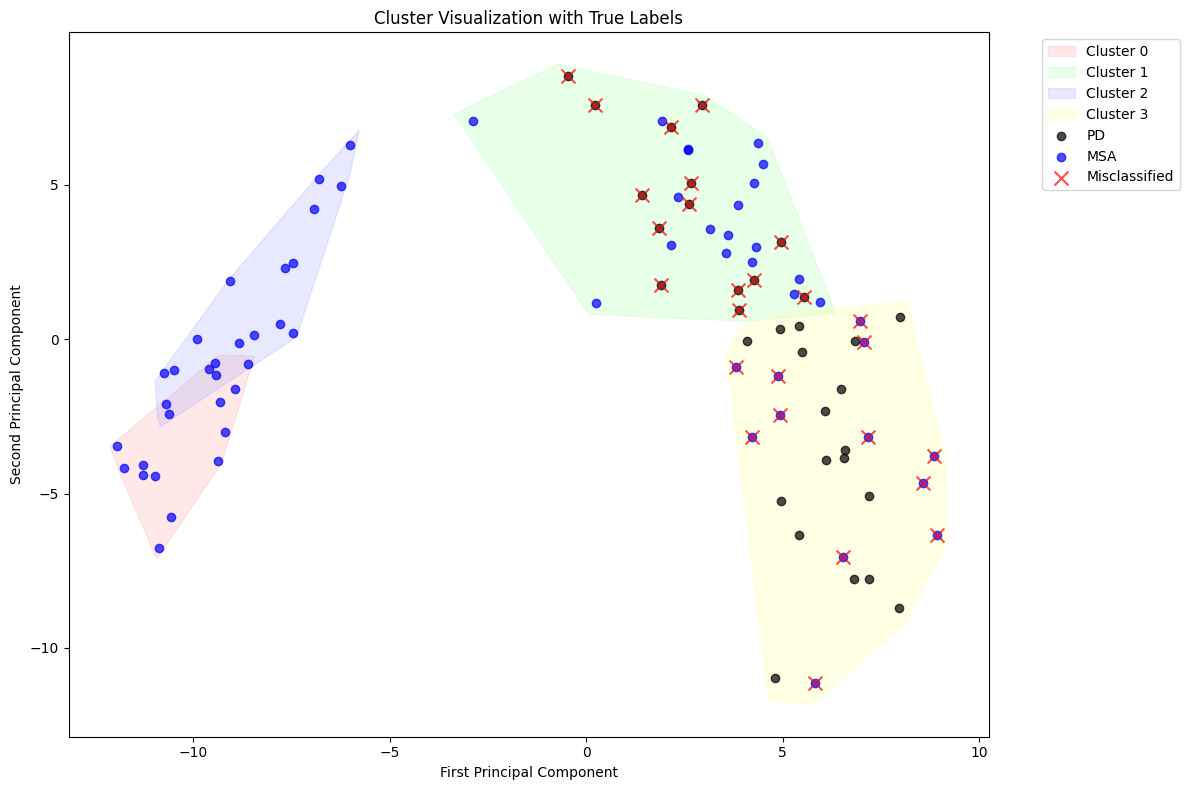

Cluster statistics:

Cluster 0: Predicted as class 1 (MSA)
  True label 1 (MSA): 13 images

Cluster 1: Predicted as class 1 (MSA)
  True label 0 (PD): 14 images
  True label 1 (MSA): 19 images

Cluster 2: Predicted as class 1 (MSA)
  True label 1 (MSA): 18 images

Cluster 3: Predicted as class 0 (PD)
  True label 0 (PD): 18 images
  True label 1 (MSA): 12 images
Adjusted Rand Index (ARI): 0.053
Normalized Mutual Information (NMI): 0.191


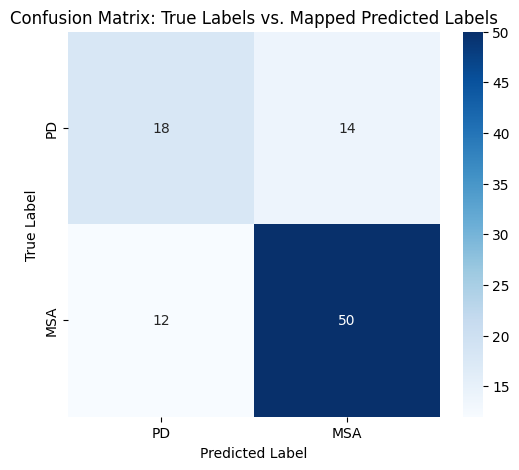

{'ari': 0.052665514180255106,
 'nmi': 0.19072060638030985,
 'confusion_matrix': array([[18, 14],
        [12, 50]]),
 'cluster_mapping': {0: 1, 1: 1, 2: 1, 3: 0},
 'predicted_labels': array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 0])}

In [ ]:
print("Features shape before K-Means:", features_list.shape)
# Optionally, you could also cluster on PCA-reduced features,
# but here we cluster on the original features.
n_clusters = 4# Change if needed.
# features_list = PCA(n_components=5).fit_transform(features_list)
raw_cluster_labels, predicted_labels, cluster_to_class_dict = perform_clustering(features_list, true_labels, n_clusters, class0_name, class1_name)

#plot_clusters_2d(features_list, true_labels, raw_cluster_labels, predicted_labels, cluster_to_class_dict, class0_name, class1_name)  

plot_clusters_2dx(features_list, true_labels, raw_cluster_labels, predicted_labels, class0_name, class1_name)
# -------------------------------
# Step 5: Print per-cluster info and misclassifications
# -------------------------------
# Optionally, print the number of images in each cluster by true label.
print("Cluster statistics:")
for cl in np.unique(raw_cluster_labels):
    indices = np.where(raw_cluster_labels == cl)[0]
    cluster_true = [true_labels[i] for i in indices]
    predicted_class = cluster_to_class_dict[cl]
    print(f"\nCluster {cl}: Predicted as class {predicted_class} ({class0_name if predicted_class==0 else class1_name})")
    for label in np.unique(cluster_true):
        count = sum(1 for x in cluster_true if x == label)
        print(f"  True label {label} ({class0_name if label==0 else class1_name}): {count} images")
        
evaluate_cluster(true_labels, raw_cluster_labels,class0_name,class1_name)

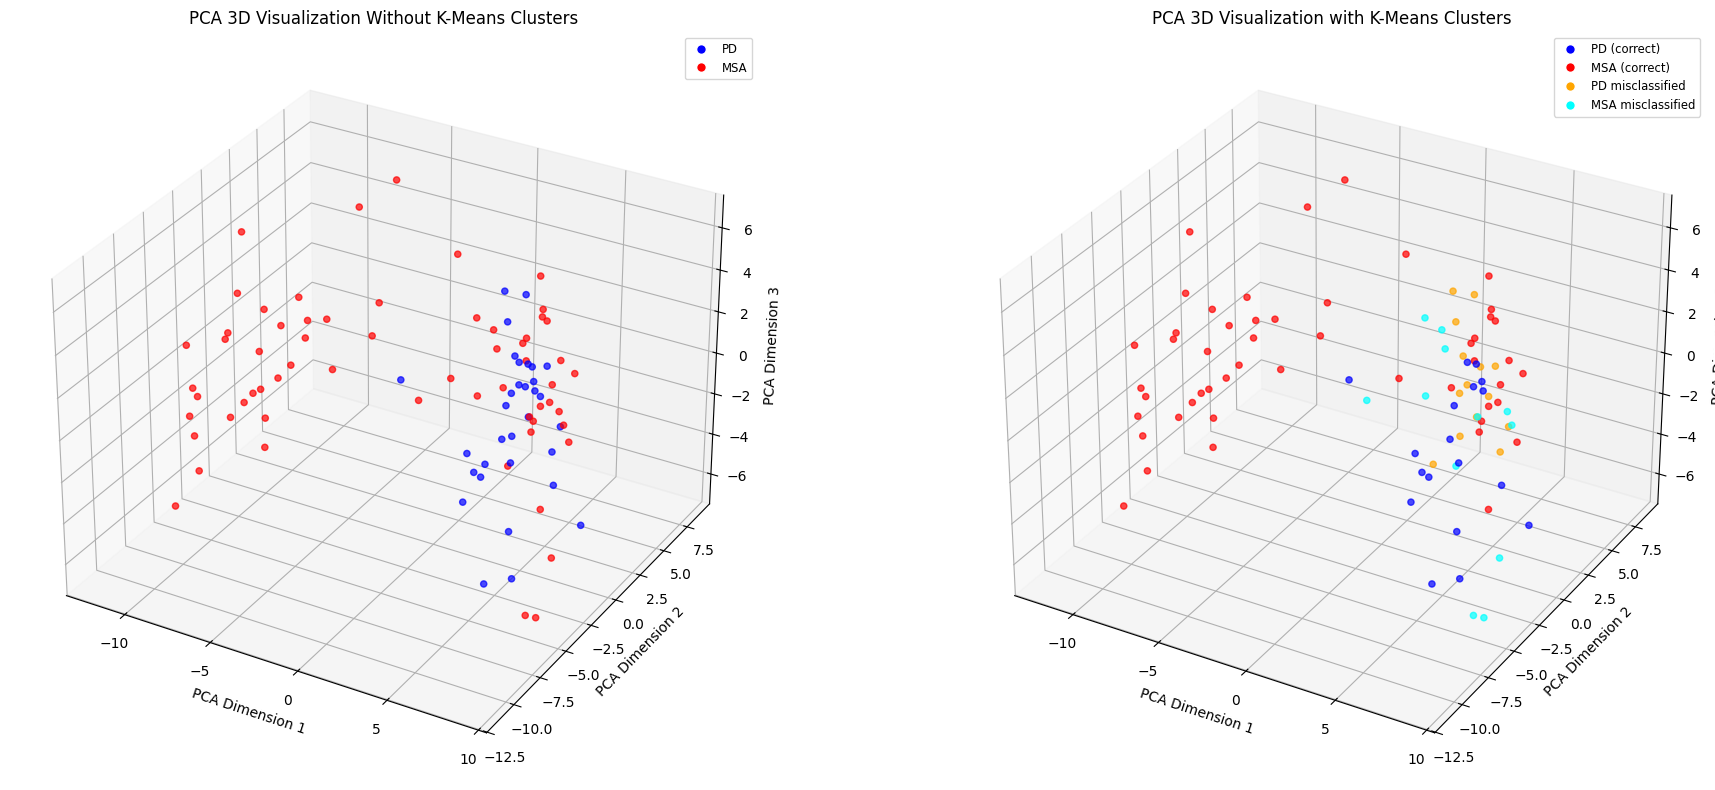

In [ ]:
# Create a figure with two side-by-side subplots
fig = plt.figure(figsize=(20, 8))

# First subplot - Without K-means clusters (now first)
ax1 = fig.add_subplot(121, projection='3d')
correct_color_map = {0: "blue", 1: "red"}
true_point_colors = [correct_color_map[label] for label in labels]
pca_3d = PCA(n_components=3, random_state=42)
features_pca3d = pca_3d.fit_transform(features_pca)
sc1 = ax1.scatter(features_pca3d[:, 0],
                 features_pca3d[:, 1],
                 features_pca3d[:, 2],
                 c=true_point_colors, alpha=0.7)
ax1.set_title("PCA 3D Visualization Without K-Means Clusters")
ax1.set_xlabel("PCA Dimension 1")
ax1.set_ylabel("PCA Dimension 2")
ax1.set_zlabel("PCA Dimension 3")

# Second subplot - With K-means clusters (now second)
ax2 = fig.add_subplot(122, projection='3d')
final_point_colors = [get_color(t, p) for t, p in zip(true_labels, predicted_labels)]
sc2 = ax2.scatter(features_pca3d[:, 0],
                 features_pca3d[:, 1],
                 features_pca3d[:, 2],
                 c=final_point_colors, alpha=0.7)
ax2.set_title("PCA 3D Visualization with K-Means Clusters")
ax2.set_xlabel("PCA Dimension 1")
ax2.set_ylabel("PCA Dimension 2")
ax2.set_zlabel("PCA Dimension 3")

# Create legends (order switched to match plots)
legend_elements1 = [
    Line2D([0], [0], marker='o', color='w', label=f"{class0_name}", markerfacecolor="blue", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class1_name}", markerfacecolor="red", markersize=10),
]

legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', label=f"{class0_name} (correct)", markerfacecolor="blue", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class1_name} (correct)", markerfacecolor="red", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class0_name} misclassified", markerfacecolor="orange", markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"{class1_name} misclassified", markerfacecolor="cyan", markersize=10)
]

ax1.legend(handles=legend_elements1, fontsize='small', markerscale=0.7)
ax2.legend(handles=legend_elements2, fontsize='small', markerscale=0.7)

plt.tight_layout()
plt.show()

In [ ]:
#shows each cluster in a different color
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from utils.data_visualization_functions import visualize_tiff

# Create a DataFrame that holds your metadata.
df = pd.DataFrame({
    'x': features_pca3d[:, 0],
    'y': features_pca3d[:, 1],
    'z': features_pca3d[:, 2],
    'label': raw_cluster_labels,
    'image_path': image_paths,  # full paths or names for your images
})

# Define a discrete color mapping for your classes.
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'black'}
true_point_colors = [color_map[label] for label in df['label']]

# Create an interactive 3D scatter plot using Plotly FigureWidget.
fig = go.FigureWidget(data=[go.Scatter3d(
    x=df['x'],
    y=df['y'],
    z=df['z'],
    mode='markers',
    marker=dict(
        size=5,
        color=true_point_colors
    ),
    # Save the image path in customdata to access in the callback.
    customdata=df['image_path'],
    # Set a hovertemplate to show the image path on hover.
    hovertemplate="Image: %{customdata}<extra></extra>"
)])
fig.update_layout(
    title='Interactive 3D t-SNE Visualization',
    scene=dict(
        xaxis_title='t-SNE Dimension 1',
        yaxis_title='t-SNE Dimension 2',
        zaxis_title='t-SNE Dimension 3'
    ),
    width=1000,  # Set the width (in pixels)
    height=1000
)

# Create an Output widget to display messages and images.
output = widgets.Output()
display(output)

# Define the click callback function using the Output widget.
def click_fn(trace, points, state):
    if points.point_inds:
        idx = points.point_inds[0]
        image_path = trace.customdata[idx]
        with output:
            output.clear_output(wait=True)
            print("Clicked on image:", image_path)
            try:
                visualize_tiff(image_path)
            except Exception as e:
                print("Error displaying image:", e)

# Attach the callback to the scatter trace.
fig.data[0].on_click(click_fn)

# Display the interactive figure.
fig

Output()

FigureWidget({
    'data': [{'customdata': array(['/home/zano/Documents/TESI/3c_version/MSA/MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh2_3ch.tif',
                                   '/home/zano/Documents/TESI/3c_version/MSA/MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhol

In [ ]:
from utils.clustering_functions import get_cluster_image_names, compute_cluster_mapping

# Get cluster image names
cluster_images = get_cluster_image_names(image_paths, raw_cluster_labels)

# Get cluster to class mapping (majority class for each cluster)
cluster_to_class = compute_cluster_mapping(true_labels, raw_cluster_labels)

# For each cluster, analyze class distribution
for cluster_id, image_names in cluster_images.items():
    # Get color of this cluster
    cluster_color = color_map.get(cluster_id, 'gray')
    
    # Get indices of images in this cluster
    cluster_indices = np.where(raw_cluster_labels == cluster_id)[0]
    
    # Count images of each class in this cluster
    class0_count = np.sum(true_labels[cluster_indices] == 0)
    class1_count = np.sum(true_labels[cluster_indices] == 1)
    
    # Get majority class name
    majority_class = class0_name if cluster_to_class[cluster_id] == 0 else class1_name
    
    # Print summary
    print(f"\nCluster {cluster_id} (Color: {cluster_color}) contains {len(image_names)} images:")
    print(f"  - {class0_name}: {class0_count} images ({class0_count/len(cluster_indices):.1%})")
    print(f"  - {class1_name}: {class1_count} images ({class1_count/len(cluster_indices):.1%})")
    print(f"  - Majority class: {majority_class}")

    num_images_to_print = 5
    # Print a few image names
    print("  - Sample images:")
    for img in image_names[:num_images_to_print]:
        print(f"    * {img}")
    if len(image_names) > num_images_to_print:
        print(f"    * ... and {len(image_names) - num_images_to_print} more")


Cluster 3 (Color: yellow) contains 30 images:
  - PD: 18 images (60.0%)
  - MSA: 12 images (40.0%)
  - Majority class: PD
  - Sample images:
    * MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif
    * MAX_5358.lif - 5358 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif
    * MAX_5767.lif - 5767 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh pinhole 1 z 05_3ch.tif
    * MAX_5767.lif - 5767 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh2 pinhole 1 z 05_3ch.tif
    * MAX_5878.lif - 5878 DL VIP r TH b Sinapto gr DAPI grey 63x z2 gh2 pinhole 1 z 05_3ch.tif
    * ... and 25 more

Cluster 1 (Color: blue) contains 33 images:
  - PD: 14 images (42.4%)
  - MSA: 19 images (57.6%)
  - Majority class: MSA
  - Sample images:
    * MAX_4092.lif - 4092 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif
    * MAX_4121.lif - 4121 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif
    * MAX_4121.lif - 4121 DL VI

In [ ]:
from IPython.display import display, HTML

for cluster_id, image_names in cluster_images.items():
    # Get color and indices
    cluster_color = color_map.get(cluster_id, 'gray')
    cluster_indices = np.where(raw_cluster_labels == cluster_id)[0]
    
    # Count class distribution
    class0_count = np.sum(true_labels[cluster_indices] == 0)
    class1_count = np.sum(true_labels[cluster_indices] == 1)
    
    # Get majority class
    majority_class = class0_name if cluster_to_class[cluster_id] == 0 else class1_name
    
    # Create HTML output
    color_box = f'<div style="display:inline-block; width:20px; height:20px; background-color:{cluster_color}; margin-right:5px;"></div>'
    
    html = f"{color_box} <b>Cluster {cluster_id}</b> ({len(image_names)} total images)<br>"
    html += f"<ul>"
    html += f"<li><b>{class0_name}:</b> {class0_count} images ({class0_count/len(cluster_indices):.1%})</li>"
    html += f"<li><b>{class1_name}:</b> {class1_count} images ({class1_count/len(cluster_indices):.1%})</li>"
    html += f"<li><b>Majority class:</b> {majority_class}</li>"
    html += "</ul>"
    
    display(HTML(html))

## K MEAN CLASSIFIER

In [ ]:
from utils.image_processing_functions import extract_images_features
from sklearn.decomposition import PCA
from monai.transforms import Lambda
from classes.PrintShapeTransform import PrintShapeTransform
# ---------------------
# 4. Feature Extraction from test and train test images
# ---------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(
    spatial_dims=2,
    in_channels=3,
    out_channels=2,
    pretrained=True,
).to(device)

# model = load_mlflow_model(tracking_uri, experiment_name, gdrive,kaggle,linux)

feature_extractor = FeatureExtractorWrapper(model).to(device)

from monai.transforms import LoadImaged, EnsureChannelFirstd, LambdaD, Resized, ScaleIntensityd, Compose

transforms = Compose([
    LoadImaged(keys="image", reader="ITKReader"),
    #PrintShapeTransform(keys=["image"], tag="After LoadImaged", print_stats=True),
    EnsureChannelFirstd(keys="image", channel_dim=-1),
    #PrintShapeTransform(keys=["image"], tag="After ensure channel", print_stats=True),
    LambdaD(keys="image", func=lambda x: x[:3, ...]),  # keep only first 3 channels
    #PrintShapeTransform(keys=["image"], tag="After LamdaD", print_stats=True),
    Resized(keys="image", spatial_size=cfg.data_augmentation["resize_spatial_size"]),
    PrintShapeTransform(keys=["image"], tag="After Resized", print_stats=True),
    ScaleIntensityd(keys="image"),
])

train_true_labels = np.array(labels)
# extract test data and labels

# test_dir = os.path.join(data_dir, "TEST")
# #test_dir = os.path.join(data_dir, "MIX1")
# test_images_paths = list(sorted(glob.glob(os.path.join(test_dir, "*.tif"))))
# print(f"class 0:{class0_name} class 1:{class1_name}")

def check_image_shapes(image_paths):
    import tifffile as tiff
    if not image_paths:
        print("No images found.")
        return

    with tiff.TiffFile(image_paths[0]) as tif:
        first_image = tif.asarray()
    
    expected_shape = first_image.shape
    print(f"Expected image shape: {expected_shape}")

    for path in image_paths[1:]:
        with tiff.TiffFile(path) as tif:
            image = tif.asarray()
        
        if image.shape != expected_shape:
            print(f"Shape mismatch: {path} has shape {image.shape}, expected {expected_shape}")
            return
    
    print("All images have the same shape.")

#check_image_shapes(test_images_paths)
# test_msa_ids = [7144,7120,7239,7293]
# test_pd_ids = [7155,7222,7229,7284]

# test_true_labels = [get_label(path,test_msa_ids,test_pd_ids) for path in test_images_paths]
# test_true_labels = np.array(test_true_labels)
print(f"Found {len(test_images_paths)} test images.")
print(test_images_paths)
print(test_true_labels)

#extract features from train and test images
train_features_list = extract_images_features(images_paths, feature_extractor, transforms)
test_features_list = extract_images_features(test_images_paths, feature_extractor, transforms)
print("FINISHED FEATURE EXTRACTION")
print("single feature shape:",test_features_list[0].shape)
print("total features:",len(test_features_list))

Found 15 test images.
['/home/zano/Documents/TESI/3c_version/PD/MAX_6577.lif - 6577 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_7229.lif - 7229 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/MSA/MAX_6179.lif - 6179 DL VIP r TH b Sinapto gr 63x z2 gh2 pinhole 1 z 05_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_6340.lif - 6340 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh  n2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/MSA/MAX_7144.lif - 7144 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/MSA/MAX_6085.lif - 6085 DL VIP r Sinapto gr TH b 63x z2 gh pinhole 1 z 05_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/PD/MAX_6366.lif - 6366 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh n2_3ch.tif'
 '/home/zano/Documents/TESI/3c_version/MSA/MAX_5753.lif - 5753

In [ ]:
# ---------------------
# 5. Dimensionality Reduction with PCA
# ---------------------
pca = PCA(n_components=45) # Reduce the feature vector dimensionality to (N_images, n_components), keep components until they explain 95% or more of variance
train_features_pca = pca.fit_transform(train_features_list)
test_features_pca = pca.transform(test_features_list)
print("Train features shape after PCA:", train_features_pca.shape)
print("Test features shape after PCA:", test_features_pca.shape)
print("FINISHED FEATURE EXTRACTION")
print("Original feature shape:", train_features_list[0].shape)
print("Total features:", len(train_features_list))
print("PCA Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Cumulative Explained Variance:", np.cumsum(pca.explained_variance_ratio_))

Train features shape after PCA: (94, 45)
Test features shape after PCA: (15, 45)
FINISHED FEATURE EXTRACTION
Original feature shape: (1024,)
Total features: 94
PCA Explained Variance Ratio: [0.42755905 0.1740847  0.07878617 0.04398167 0.02678469 0.02322315
 0.0204649  0.01777588 0.014918   0.01258733 0.01181941 0.01049438
 0.00933211 0.00739411 0.00712856 0.00656876 0.0057102  0.0053653
 0.00499461 0.00452022 0.00441725 0.00389977 0.00379877 0.00366873
 0.00342643 0.00328744 0.00294533 0.00292661 0.00262149 0.00240008
 0.00234665 0.00224653 0.00209567 0.0019343  0.00193008 0.00179863
 0.0017763  0.00170916 0.00168244 0.00151079 0.00144382 0.00140441
 0.00135586 0.00126354 0.00125866]
Cumulative Explained Variance: [0.42755905 0.60164374 0.68042994 0.7244116  0.7511963  0.7744195
 0.7948844  0.8126603  0.8275783  0.8401656  0.85198504 0.8624794
 0.8718115  0.87920564 0.8863342  0.8929029  0.8986131  0.9039784
 0.90897304 0.9134933  0.9179105  0.92181027 0.92560905 0.9292778
 0.9327042  

Testing with 2 clusters...
Clusters: 2, Accuracy: 0.600, F1: 0.571
Testing with 3 clusters...
Clusters: 3, Accuracy: 0.600, F1: 0.571
Testing with 4 clusters...
Clusters: 4, Accuracy: 0.667, F1: 0.737
Testing with 5 clusters...
Clusters: 5, Accuracy: 0.600, F1: 0.625
Testing with 6 clusters...
Clusters: 6, Accuracy: 0.600, F1: 0.625
Testing with 7 clusters...
Clusters: 7, Accuracy: 0.600, F1: 0.700
Testing with 8 clusters...
Clusters: 8, Accuracy: 0.667, F1: 0.706
Testing with 9 clusters...
Clusters: 9, Accuracy: 0.533, F1: 0.632
Testing with 10 clusters...
Clusters: 10, Accuracy: 0.733, F1: 0.778
Testing with 11 clusters...
Clusters: 11, Accuracy: 0.600, F1: 0.727
Testing with 12 clusters...
Clusters: 12, Accuracy: 0.600, F1: 0.667
Testing with 13 clusters...
Clusters: 13, Accuracy: 0.600, F1: 0.667
Testing with 14 clusters...
Clusters: 14, Accuracy: 0.600, F1: 0.667
Testing with 15 clusters...
Clusters: 15, Accuracy: 0.533, F1: 0.632
Testing with 16 clusters...
Clusters: 16, Accuracy

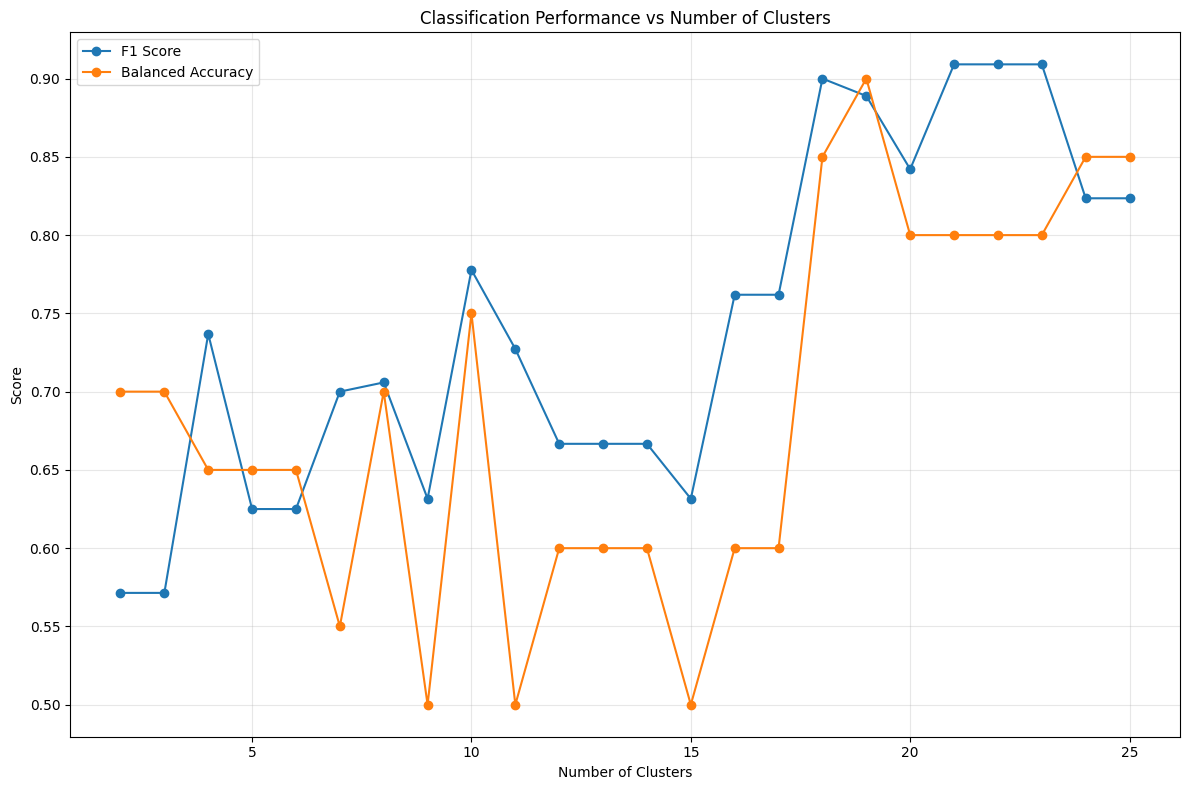

Best number of clusters: 21 with F1 score: 0.909


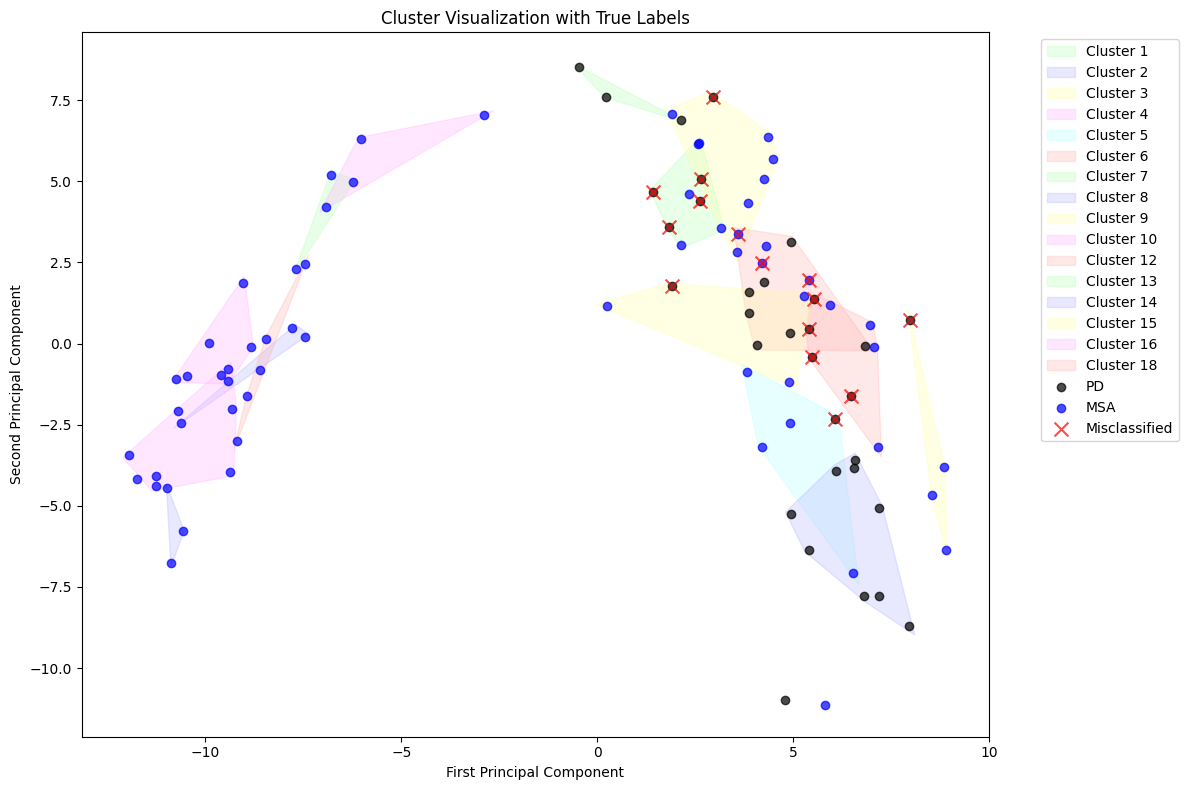

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

# Define range of clusters to test
min_clusters = 2  # Minimum should be at least the number of classes
max_clusters = 25
cluster_range = range(min_clusters, max_clusters + 1)

# Initialize lists to store metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
bal_accs = []

# Loop through each cluster count
for n_clusters in cluster_range:
    print(f"Testing with {n_clusters} clusters...")
    
    # Train K-Means on the training PCA features
    kmeans = KMeans(n_clusters=n_clusters, random_state=cfg.data_splitting["random_seed"])
    train_cluster_labels = kmeans.fit_predict(train_features_pca)
    
    # Map clusters to class labels via majority voting
    train_cluster_mappings = compute_cluster_mapping(train_true_labels, train_cluster_labels)
    
    # Predict cluster assignments for test data
    test_predicted_cluster_labels = kmeans.predict(test_features_pca)
    
    # Map clusters to classes
    predicted_test_labels = np.array([train_cluster_mappings[cl] for cl in test_predicted_cluster_labels])
    
    # Compute metrics
    accuracy = accuracy_score(test_true_labels, predicted_test_labels)
    precision = precision_score(test_true_labels, predicted_test_labels)
    recall = recall_score(test_true_labels, predicted_test_labels)
    f1 = f1_score(test_true_labels, predicted_test_labels)
    bal_acc = balanced_accuracy_score(test_true_labels, predicted_test_labels)
    
    # Store metrics
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    bal_accs.append(bal_acc)
    
    print(f"Clusters: {n_clusters}, Accuracy: {accuracy:.3f}, F1: {f1:.3f}")

# Plot results
plt.figure(figsize=(12, 8))
# plt.plot(cluster_range, accuracies, 'o-', label='Accuracy')
# plt.plot(cluster_range, precisions, 'o-', label='Precision')
# plt.plot(cluster_range, recalls, 'o-', label='Recall')
plt.plot(cluster_range, f1_scores, 'o-', label='F1 Score')
plt.plot(cluster_range, bal_accs, 'o-', label='Balanced Accuracy')

plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Classification Performance vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Find best number of clusters based on F1 score
best_cluster_count = cluster_range[np.argmax(f1_scores)]
print(f"Best number of clusters: {best_cluster_count} with F1 score: {max(f1_scores):.3f}")
s import ConfigLoaderbels, raw_cluster_labels, predicted_labels, class0_name, class1_name)
#plot_clusters_2dx(test_features_pca, test_true_labels, test_predicted_cluster_labels, predicted_test_labels, class0_name, class1_name)

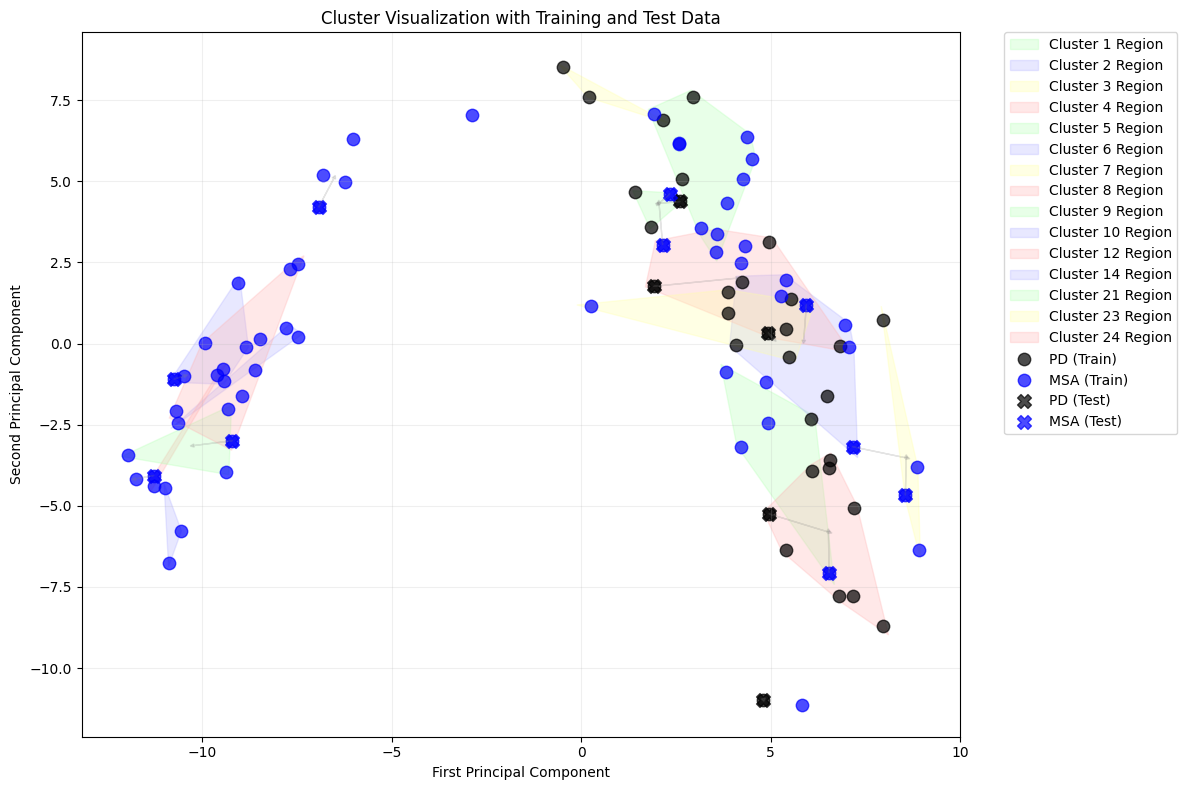

In [ ]:
def plot_clusters_with_test(train_features, train_true_labels, train_cluster_labels, 
                          test_features, test_true_labels,
                          class0_name="Class 0", class1_name="Class 1"):
    """
    Plot clusters from training data and show test data positioning.
    performs PCA to reduce dimensionality to 2D for visualization.
    
    Args:
        train_features: Training feature matrix
        train_true_labels: Training ground truth labels
        train_cluster_labels: Training cluster assignments
        test_features: Test feature matrix
        test_true_labels: Test ground truth labels
        cluster_to_class_mapping: Dictionary mapping cluster IDs to predicted classes
        class0_name: Name for class 0 (default: "Class 0")
        class1_name: Name for class 1 (default: "Class 1")
    """
    # Reduce dimensionality to 2D using PCA
    pca_2d = PCA(n_components=2, random_state=42)
    # Fit PCA on training data and transform both train and test
    train_pca2d = pca_2d.fit_transform(train_features)
    test_pca2d = pca_2d.transform(test_features)
    
    # Create figure and axis
    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    
    # Define color schemes
    cluster_colors = ['#FFB3B3', '#B3FFB3', '#B3B3FF', '#FFFFA8']  # Pastel colors for clusters
    label_colors = ['#000000', '#0000FF']  # Black for class 0, Blue for class 1
    
    # Plot cluster backgrounds using convex hull for training data
    from scipy.spatial import ConvexHull
    
    for i, cluster_id in enumerate(np.unique(train_cluster_labels)):
        # Get points belonging to the cluster
        mask = train_cluster_labels == cluster_id
        cluster_points = train_pca2d[mask]
        
        if len(cluster_points) > 2:  # Need at least 3 points for ConvexHull
            hull = ConvexHull(cluster_points)
            hull_points = cluster_points[hull.vertices]
            
            # Add padding to hull
            centroid = np.mean(hull_points, axis=0)
            hull_points = hull_points + (hull_points - centroid) * 0.1
            
            plt.fill(hull_points[:, 0], hull_points[:, 1],
                    color=cluster_colors[i % len(cluster_colors)],
                    alpha=0.3,
                    label=f'Cluster {cluster_id} Region')
    
    # Plot training points
    for label in [0, 1]:
        mask = train_true_labels == label
        plt.scatter(train_pca2d[mask, 0], 
                   train_pca2d[mask, 1],
                   c=[label_colors[label]],
                   marker='o',
                   s=80,
                   alpha=0.7,
                   label=f'{class0_name if label == 0 else class1_name} (Train)')
    
    # Plot test points with different markers
    for label in [0, 1]:
        mask = test_true_labels == label
        plt.scatter(test_pca2d[mask, 0],
                   test_pca2d[mask, 1],
                   c=[label_colors[label]],
                   marker='X',
                   s=100,
                   alpha=0.7,
                   label=f'{class0_name if label == 0 else class1_name} (Test)')
    
    # Add arrows from test points to their nearest cluster centroid
    train_centroids = {}
    for cluster_id in np.unique(train_cluster_labels):
        mask = train_cluster_labels == cluster_id
        centroid = np.mean(train_pca2d[mask], axis=0)
        train_centroids[cluster_id] = centroid
    
    # Calculate and plot nearest centroid connections for test points
    from scipy.spatial.distance import cdist
    
    # Calculate distances between test points and cluster centroids
    centroids = np.array(list(train_centroids.values()))
    for i in range(len(test_pca2d)):
        # Find nearest centroid
        distances = cdist([test_pca2d[i]], centroids)
        nearest_idx = np.argmin(distances)
        nearest_centroid = centroids[nearest_idx]
        
        # Draw arrow with low opacity
        plt.arrow(test_pca2d[i, 0], test_pca2d[i, 1],
                 nearest_centroid[0] - test_pca2d[i, 0],
                 nearest_centroid[1] - test_pca2d[i, 1],
                 head_width=0.1, head_length=0.1, fc='gray', ec='gray',
                 alpha=0.2)
    
    # Customize plot
    plt.title("Cluster Visualization with Training and Test Data")
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    
    # Add grid with low opacity
    plt.grid(True, alpha=0.2)
    
    # Create legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
              borderaxespad=0., frameon=True, fancybox=True)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Usage example:
fig = plot_clusters_with_test(
    train_features=train_features_pca,
    train_true_labels=train_true_labels,
    train_cluster_labels=train_cluster_labels,
    test_features=test_features_pca,
    test_true_labels=test_true_labels,
    class0_name=class0_name,
    class1_name=class1_name
)

plt.show()

Visualizing Train vs Test Clusters:
Train features shape: (94, 45)
Test features shape: (15, 45)
Train labels shape: (94,)
Test labels shape: (15,)
Predicted test labels shape: (15,)


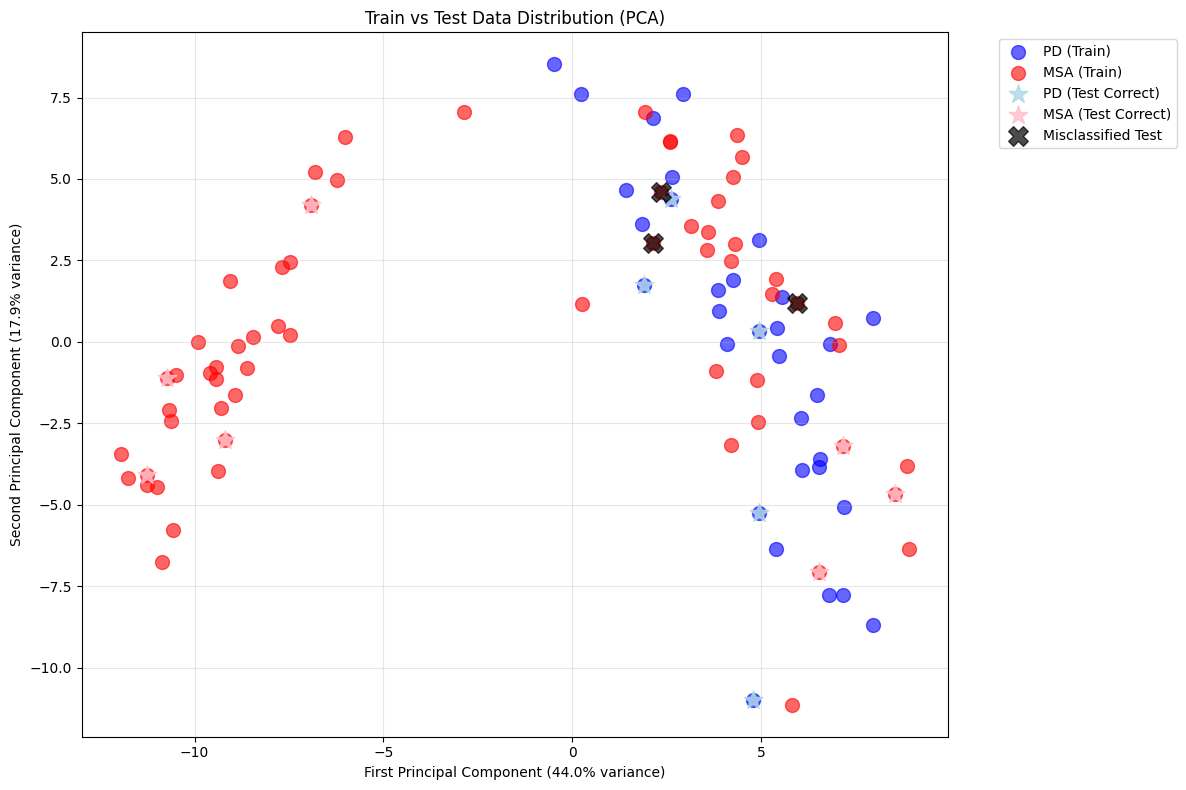

In [ ]:
def plot_train_test_clusters(train_features: np.ndarray,
                           test_features: np.ndarray,
                           train_labels: np.ndarray,
                           test_labels: np.ndarray,
                           predicted_test_labels: np.ndarray,
                           random_seed: int = 42,
                           class0_name: str = "Class 0",
                           class1_name: str = "Class 1") -> None:
    """
    Visualizes train and test data in 2D using PCA, highlighting the relationship
    between training and test samples and their classifications.

    Args:
        train_features (np.ndarray): Training feature matrix
        test_features (np.ndarray): Test feature matrix
        train_labels (np.ndarray): True labels for training data
        test_labels (np.ndarray): True labels for test data
        predicted_test_labels (np.ndarray): Predicted labels for test data
        random_seed (int): Random seed for PCA
        class0_name (str): Name for class 0
        class1_name (str): Name for class 1
    """
    plt.figure(figsize=(12, 8))

    # Fit PCA on training data only
    pca = PCA(n_components=2, random_state=random_seed)
    train_features_2d = pca.fit_transform(train_features)
    
    # Transform test features using the same PCA
    test_features_2d = pca.transform(test_features)

    # Plot training points
    for label in [0, 1]:
        mask = train_labels == label
        plt.scatter(train_features_2d[mask, 0], 
                   train_features_2d[mask, 1],
                   marker='o',
                   s=100,
                   label=f'{class0_name if label == 0 else class1_name} (Train)',
                   alpha=0.6,
                   color='blue' if label == 0 else 'red')

    # Plot test points - correctly classified
    for label in [0, 1]:
        correct_mask = (test_labels == label) & (predicted_test_labels == label)
        plt.scatter(test_features_2d[correct_mask, 0],
                   test_features_2d[correct_mask, 1],
                   marker='*',
                   s=200,
                   label=f'{class0_name if label == 0 else class1_name} (Test Correct)',
                   alpha=0.8,
                   color='lightblue' if label == 0 else 'pink')

    # Plot misclassified test points
    misclassified = test_labels != predicted_test_labels
    if np.any(misclassified):
        plt.scatter(test_features_2d[misclassified, 0],
                   test_features_2d[misclassified, 1],
                   marker='X',
                   s=200,
                   c='black',
                   label='Misclassified Test',
                   alpha=0.7)

    # Customize plot
    plt.title('Train vs Test Data Distribution (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Optional: Add explained variance ratio
    var_ratio = pca.explained_variance_ratio_
    plt.xlabel(f'First Principal Component ({var_ratio[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component ({var_ratio[1]:.1%} variance)')
    
    plt.tight_layout()
    plt.show()

print("Visualizing Train vs Test Clusters:")
print("Train features shape:", train_features_pca.shape)
print("Test features shape:", test_features_pca.shape)
print("Train labels shape:", train_true_labels.shape)
print("Test labels shape:", test_true_labels.shape)
print("Predicted test labels shape:", predicted_test_labels.shape)
   
plot_train_test_clusters(
    train_features=train_features_pca,
    test_features=test_features_pca,
    train_labels=train_true_labels,
    test_labels=test_true_labels,
    predicted_test_labels=predicted_test_labels,
    random_seed=cfg.data_splitting["random_seed"],
    class0_name=class0_name,
    class1_name=class1_name,
)

# SUPERVISED LEARNING


## training augmentations

In [ ]:
from configs import ConfigLoader
from utils.train_functions import (
    train_epoch,
    val_epoch,
    #setup_model,
    print_model_summary,
    plot_cv_results,
    train_epoch_mixUp,
    print_layers,
    oversample_minority,
    undersample_majority,
    freeze_layers_up_to,
    freeze_layers_up_to_progressive_ft,
    train_epoch_vit,
    val_epoch_vit,
    )

import utils.transformations_functions as tf
import utils.monai_transformation_functions as mtf
from configs.ConfigLoader import ConfigLoader

from classes.ModelManager import ModelManager
available_models = ["densenet121", "resnet18", "resnet18", "resnet50"]

yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/densenet121.yaml"
cfg = ConfigLoader(yaml_path) 
cfg.set_freezed_layer_index(None)
transfer_learning = cfg.get_transfer_learning()
pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet" or 'imagenet-microscopynet' 
assert pretrained_weights in [None,"microscopynet", "imagenet", "imagenet-microscopynet"], "pretrained_weights must be one of [None, 'microscopynet', 'imagenet', 'imagenet-microscopynet']"
            # indicates that the encoder was first pretrained on imagenet and then finetuned on microscopynet
model_library = "monai" # or "torchvision" or "monai" pretraining dataset, either 'microscopynet' or 
assert model_library in ["torchvision", "monai"], "model_library must be one of ['torchvision', 'monai']"
color_transforms = False
train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg, color_transforms=color_transforms)
# train_transforms, val_transforms, test_transforms = mtf.get_transforms(cfg, color_transforms=color_transforms)
model_manager = ModelManager(cfg, library=model_library)
# Verify the number of unique labels in the dataset
num_classes = len(np.unique(train_labels_np))
# print(f"Number of classes in the dataset: {num_classes}")
using_cosine_scheduler = False
# Ensure the model's output matches the number of classes
model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)
# model = model.to(device)  # First, move to the target device
# model = model.float() 
print(model)
# print(cfg.get_model_input_channels())

# if model.__class__.__name__ == "ViT":
#     print("Using ViT hence it requires custom training and validation functions")
#     train_epoch = train_epoch_vit
#     val_epoch = val_epoch_vit

## TRAINING

## NESTED K FOLD WITH HYP(LR) TUNING

This code trains an image classifier using nested cross-validation.
The outer loop evaluates the model's performance, while the inner loop (using Optuna) tunes the learning rate.
For each outer fold, Optuna finds the best learning rate by minimizing validation loss on inner folds.
The model is then retrained on the entire outer training set with this optimal learning rate and evaluated on the outer set. The final results are the average performance metrics across all outer folds. Techniques like oversampling, undersampling, and early stopping are used to improve the model's robustness and generalization.

NB: total number of epoch: n_outer_folds × n_trials × n_inner_folds × inner_num_epochs.

### outer test as test


new vesion of lr hyp nested cv keeping the outer test for test only and using hold out validation to choose the best model

## STRATIFYING BY PATIENT ID

In [ ]:
import pandas as pd
import re
def extract_patient_id(image_path):
    # Example: parse from the file name
    # In real code, you might have a different pattern
    match = re.search(r'(\d{4})', image_path)
    if match:
        return match.group(1)
    else:
        return "UNKNOWN"

# Build a DataFrame
df = pd.DataFrame({
    "image_path": images_paths_np,
    "label": labels_np
})

df["patient_id"] = df["image_path"].apply(extract_patient_id) # extract the patient id from the image path and create a new column
display(df)

# Ensure everything is string or int
df["patient_id"] = df["patient_id"].astype(str) # convert the patient id to a string

# Now group by patient to get a single label per patient.
# If every patient truly has exactly one label, we can just take .first()
# create a patient_label_df by filtering df patient_label_df( "patient_id","label")
patient_label_df = df.groupby("patient_id", as_index=False)["label"].first() # group by patient id and take the first label for each patient
display(patient_label_df)

unique_pat_ids = patient_label_df["patient_id"].values  # we need these to stratify for patient
print(f"Unique patient IDs: {unique_pat_ids}")
print(f"Number of unique patients: {len(unique_pat_ids)}")
pat_labels     = patient_label_df["label"].values
print(f"Unique patient labels: {pat_labels}")

display(patient_label_df)

# Determine the number of classes automatically from the dataset labels
unique_overall_labels = np.unique(labels_np) # Or df['label'].unique()
num_classes = len(unique_overall_labels)
print(f"Detected {num_classes} unique classes: {sorted(unique_overall_labels)}")

# Crucial Check: Ensure labels are 0, 1, ..., N-1 for nn.CrossEntropyLoss
expected_labels = set(range(num_classes)) # set of all possible labels (0...N-1)
actual_labels = set(unique_overall_labels) # set of all actual labels found in labels_np
if expected_labels != actual_labels:
    # Depending on your data, you might raise an error or attempt re-encoding.
    # If labels are e.g., [1, 2, 3], they MUST be mapped to [0, 1, 2].
    raise ValueError(f"Labels must be contiguous integers starting from 0 (i.e., 0 to N-1). Found: {sorted(actual_labels)}")

## TRAINING FUNCTIONS

### FUNCTION TRAINING

In [ ]:
# import copy
# from utils.data_visualization_functions import generate_cv_results_figure
# from utils.train_functions import  SSLClassifierModule  
# from utils.train_functions import nested_cv_stratified_by_patient

# per_fold_metrics, fold_results = nested_cv_stratified_by_patient(
#     df=df,
#     cfg=cfg,
#     # model_factory=model_factory,
#     labels_np=labels_np,
#     pat_labels=pat_labels,
#     unique_pat_ids=unique_pat_ids,
#     train_transforms=train_transforms,
#     val_transforms=val_transforms,
#     pretrained_weights=pretrained_weights,
#     class_names=class_names,
#     model_manager=model_manager
# )

# fold_box_plot_fig = generate_cv_results_figure(fold_results, 'test')
# plt.show()  # If you have a plotting function

# hold_out_cv = True
# using_cosine_scheduler = False

# mean_test_acc = np.mean([r["test_acc"] for r in fold_results])
# mean_test_loss = np.mean([r["test_loss"] for r in fold_results])
# mean_test_f1 = np.mean([r["test_f1"] for r in fold_results])
# mean_test_balanced_acc = np.mean([r["test_balanced_acc"] for r in fold_results])
# mean_test_recall = np.mean([r["test_recall"] for r in fold_results])
# mean_test_precision = np.mean([r["test_precision"] for r in fold_results])


# print(f"\nMean Test Loss across outer folds: {mean_test_loss:.4f}")
# print(f"Mean Test Acc across outer folds: {mean_test_acc:.4f}")
# print(f"Mean Test F1 across outer folds: {mean_test_f1:.4f}")
# print(f"Mean Test Balanced Acc across outer folds: {mean_test_balanced_acc:.4f}")
# print(f"Mean Test Precision across outer folds: {mean_test_precision:.4f}")
# print(f"Mean Test Recall across outer folds: {mean_test_recall:.4f}")

### MEGACICLO

In [ ]:
import utils.transformations_functions as tf
from configs.ConfigLoader import ConfigLoader
from classes.ModelManager import ModelManager
# Flags ####################
transfer_learning_flag = True
########################################
available_models = ["densenet121","resnet18","resnet50"]
color_flag = False
libraries = ["torchvision"]
pretrained_weights_list = ["imagenet-microscopynet"] #!TODO use , "imagenet-microscopynet"
# pretrained_weights = None #"imagenet-microscopynet"
cfg.set_batch_size(16)
cfg.set_freezed_layer_index(None)
for model_name in available_models:
    for pretrained_weights in pretrained_weights_list:
        for library in libraries:
            yaml_path = f"/home/zano/Documents/TESI/TESI/configs/{num_input_channels}c/{model_name}.yaml"
            cfg = ConfigLoader(yaml_path) 
            cfg.set_transfer_learning(transfer_learning_flag)
            transfer_learning = cfg.get_transfer_learning()
            # if model_name == "densenet121":
            #     cfg.set_freezed_layer_index(236)
            # pretrained if needed
            # pretrained_weights = "imagenet" if transfer_learning else None # 'microscopynet' or "imagenet"
            # set the model library
            # model_library = "torchvision" # or "torchvision" or "monai"
            # color_transforms = False
            # train_transforms, val_transforms, test_transforms = tf.get_transforms(cfg,color_transforms=use_color_transform)
            model_manager = ModelManager(cfg, library=library)
            # Verify the number of unique labels in the dataset
            num_classes = len(np.unique(train_labels_np))
            print(f"Number of classes in the dataset: {num_classes}")
            using_cosine_scheduler = False
            # Ensure the model's output matches the number of classes
            model, device = model_manager.setup_model(num_classes=num_classes, pretrained_weights=pretrained_weights)

            print(model)

            from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
            # cfg.set_freezed_layer_index(None)
            experiment = NestedCVStratifiedByPatient(
                df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids,
                pretrained_weights = pretrained_weights,
                class_names = class_names,model_manager=model_manager, num_folds=6
            )
            # cfg.set_freezed_layer_index(None)

            # hold_out_cv = True
            using_cosine_scheduler = False

            per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()


            from utils.mlflow_functions import log_SSL_run_to_mlflow
            def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
                """
                Get the index of the best fold based on a specified metric.

                Args:
                    outer_fold_test_results (list of dict): List containing test results for 
                        each outer fold. Each element should be a dictionary with metrics 
                        as keys.
                    metric (str): The metric name to use for selecting the best fold. 
                        Default is "test_balanced_acc".

                Returns:
                    int: The index of the fold with the highest value for the specified metric.

                Example:
                    best_idx = get_best_fold_idx(results, metric="test_f1")
                """

                print(outer_fold_test_results)
                best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
                # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
                best_fold_result = outer_fold_test_results[best_fold_idx]
                print(f"Best {metric} Fold Result: {best_fold_result}")
                fold_idx = best_fold_result["fold"]
                return fold_idx

            #loading the best model for the metric selected, it's then used for computing gradcams during logging
            best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
            model_instance_for_logging, _ = experiment._get_model_and_device()
            model_instance_for_logging.eval()
            try:
                model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
            except FileNotFoundError:
                raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
            except Exception as e:
                raise Exception(f"Error loading model weights: {str(e)}")
            
            # Now, call the logging function:
            train_transforms, val_transforms, test_transforms = experiment.get_current_fold_transforms()
            # Now, call the logging function:
            log_SSL_run_to_mlflow(
                environmentFlags=environment_flags,
                cfg=experiment.cfg,
                model=model_instance_for_logging,
                class_names=experiment.class_names,
                fold_results = outer_fold_test_results,
                per_fold_metrics=per_fold_training_metrics,
                hold_out_cv=True, # Or experiment.cfg.path.to.hold_out_flag
                test_transforms=val_transforms,
                all_images_paths_np=images_paths_np, # Paths from the DF used in CV
                all_labels_np=experiment.labels_np, # Labels corresponding to all_images_paths_np from CV
                test_images_paths_np=test_images_paths_np, # Assuming this is a SEPARATE hold-out set
                test_true_labels_np=test_true_labels_np,   # Labels for the SEPARATE hold-out set
                yaml_path=yaml_path,
                color_transforms=color_flag, # Or experiment.cfg.path.to.color_transforms
                model_library=library,       # Or experiment.cfg.path.to.model_library
                pretrained_weights=pretrained_weights, # Or experiment.cfg.path.to.pretrained_weights
                # encoder_type="none", # If these become active, source them from experiment.cfg
                # pretrained_backbone_path = "none",
            )

In [ ]:
solve_cuda_oom()

### CLASS TRAINING

In [ ]:
from classes.NestedCVStratifiedByPatient import NestedCVStratifiedByPatient
pretrained_weights = ["microscopynet", "imagenet-microscopynet"]
pretrained_weights = "micronet"
experiment = NestedCVStratifiedByPatient(
    df=df, cfg=cfg, labels_np=labels_np, pat_labels=pat_labels, unique_pat_ids=unique_pat_ids, pretrained_weights=pretrained_weights,
    class_names=class_names,model_manager=model_manager, num_folds=6
)
# cfg.set_freezed_layer_index(None)

hold_out_cv = True
using_cosine_scheduler = False

per_fold_training_metrics, outer_fold_test_results = experiment.run_experiment()

In [ ]:
def get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc"):
    """
    Get the index of the best fold based on a specified metric.

    Args:
        outer_fold_test_results (list of dict): List containing test results for 
            each outer fold. Each element should be a dictionary with metrics 
            as keys.
        metric (str): The metric name to use for selecting the best fold. 
            Default is "test_balanced_acc".

    Returns:
        int: The index of the fold with the highest value for the specified metric.

    Example:
        best_idx = get_best_fold_idx(results, metric="test_f1")
    """

    print(outer_fold_test_results)
    best_fold_idx = np.argmax([r[metric] for r in outer_fold_test_results])
    # print(f"Best Balanced Accuracy Fold Index: {best_bac_fold_idx}")
    best_fold_result = outer_fold_test_results[best_fold_idx]
    print(f"Best {metric} Fold Result: {best_fold_result}")
    return best_fold_idx

#loading the best model for the metric selected, it's then used for computing gradcams during logging
best_fold_idx = get_best_fold_idx(outer_fold_test_results, metric="test_balanced_acc")
model_instance_for_logging, _ = experiment._get_model_and_device()
model_instance_for_logging.eval()
try:
    model_instance_for_logging.load_state_dict(torch.load(f"best_model_fold_{best_fold_idx}.pth"))
except FileNotFoundError:
    raise FileNotFoundError("Could not find best_model_fold_{best_fold_idx}.pth")
except Exception as e:
    raise Exception(f"Error loading model weights: {str(e)}")

[{'fold': 1, 'test_loss': 0.9317691922187805, 'test_acc': 0.4, 'test_f1': 0.5454545454545454, 'test_balanced_acc': 0.53125, 'test_auc': 1, 'test_precision': 0.375, 'test_recall': 1.0, 'best_lr': 0.00010541145160674452}, {'fold': 2, 'test_loss': 0.6076688170433044, 'test_acc': 0.625, 'test_f1': 0.47058823529411764, 'test_balanced_acc': 0.5928571428571429, 'test_auc': 1, 'test_precision': 0.5714285714285714, 'test_recall': 0.4, 'best_lr': 3.7364237329232583e-06}, {'fold': 3, 'test_loss': 0.5054026246070862, 'test_acc': 0.7391304347826086, 'test_f1': 0.7272727272727273, 'test_balanced_acc': 0.7658730158730158, 'test_auc': 1, 'test_precision': 0.6153846153846154, 'test_recall': 0.8888888888888888, 'best_lr': 1.3314558125891957e-05}, {'fold': 4, 'test_loss': 0.5308179259300232, 'test_acc': 0.6086956521739131, 'test_f1': 0.47058823529411764, 'test_balanced_acc': 0.5793650793650793, 'test_auc': 1, 'test_precision': 0.5, 'test_recall': 0.4444444444444444, 'best_lr': 6.575723873474018e-05}, {'f

## ENSEMBLE

In [ ]:
from typing import List, Optional
from monai.transforms import Compose
from typing import Dict, Any

# this class is needed to pass models with the proper transformation functions to the Weightedensemble
class ModelWrapper:
    def __init__(self, model: torch.nn.Module, transforms: Compose, weight: float, device: torch.device):
        self.model = model.to(device).eval()
        self.transforms = transforms
        self.weight = weight
        self.device = device

    def predict(self, batch: Dict[str, Any]) -> torch.Tensor:
        images = self.transforms(batch)["image"].to(self.device)
        with torch.no_grad():
            outputs = self.model(images)
            probs = torch.softmax(outputs, dim=1)
        return probs * self.weight

class WeightedEnsemble:
    def __init__(self, device: Optional[torch.device] = None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_wrappers: List[ModelWrapper] = []

    def add_model(self, model: torch.nn.Module, transforms: Compose, weight: float):
        # !TODO load the cfg file of the trasnforms of the model from mlflow so that each model gets the proper input transformation before inference
        self.model_wrappers.append(ModelWrapper(model, transforms, weight, self.device))

    def _normalize_weights(self):
        total_weight = sum(wrapper.weight for wrapper in self.model_wrappers)
        if total_weight == 0:
            raise ValueError("Sum of weights must be greater than zero.")
        for wrapper in self.model_wrappers:
            wrapper.weight /= total_weight

    def predict(self, dataloader: DataLoader) -> np.ndarray:
        """
        Predict labels for all samples in the dataloader using the ensemble.
        example:
            images = [
                [[1, 2, 3], [4, 5, 6], [7, 8, 9]],  # Image 1
                [[9, 8, 7], [6, 5, 4], [3, 2, 1]]   # Image 2
            ]
            
            model1_probs = [
                [0.2, 0.8],  # Probabilities for Image 1
                [0.6, 0.4]   # Probabilities for Image 2
            ]
            
            model2_probs = [
                [0.7, 0.3],  # Probabilities for Image 1
                [0.4, 0.6]   # Probabilities for Image 2
            ]
            
            weighted_model1_probs = [
                [0.4 * 0.2, 0.4 * 0.8],  # [0.08, 0.32] for Image 1
                [0.4 * 0.6, 0.4 * 0.4]   # [0.24, 0.16] for Image 2
            ]   
            
            ensemble_probs = [
                [0.08 + 0.42, 0.32 + 0.18],  # [0.50, 0.50] for Image 1
                [0.24 + 0.24, 0.16 + 0.36]   # [0.48, 0.52] for Image 2
            ]
            
            Argmax:

            For Image 1: argmax([0.50, 0.50]) -> Class 0 (assuming tie-breaking favors the first class)
            For Image 2: argmax([0.48, 0.52]) -> Class 1
        Args:
            dataloader (DataLoader): DataLoader providing batches with key 'image'.

        Returns:
            np.ndarray: Array of predicted labels.
        """
        # Normalize the weights to ensure they sum to 1
        self._normalize_weights()
        predicted_labels: List[int] = []

        # Disable gradient calculation for inference
        all_predictions = []

        with torch.no_grad():
            for batch in dataloader:
                ensemble_output = None
                for wrapper in self.model_wrappers:
                    weighted_probs = wrapper.predict(batch)
                    ensemble_output = weighted_probs if ensemble_output is None else ensemble_output + weighted_probs

                predicted_labels = ensemble_output.argmax(dim=1)
                all_predictions.extend(predicted_labels.cpu().numpy())

        return np.array(all_predictions)

from utils.path_filtering_functions import get_label
train_images_paths = images_paths_np #contains the images paths
train_true_labels = labels_np #contains the labels
print(f"{train_images_paths.shape[0]} training images")

test_dir = os.path.join(data_dir, "TEST3")
print(f"Test directory: {test_dir}")
test_images_paths = list(sorted(glob.glob(os.path.join(test_dir, "*.tif"))))
test_images_paths_np = np.array(test_images_paths)
print(f"class 0:{class0_name} class 1:{class1_name}")

#nice result if i flip the labels dont know why

test_class1_ids = [6599, 6593, 6657] #MSA
test_class0_ids = [6363, 6375, 6424, 6571, 6427, 6383, 6651, 6749]

test_true_labels = [get_label(path,test_class1_ids,test_class0_ids) for path in test_images_paths]
test_true_labels_np = np.array(test_true_labels)
print(f"Test labels: {test_true_labels_np}")

print(f"Found {len(test_images_paths)} test images.")
for img_path in test_images_paths:
    img = tifffile.imread(img_path)  # Use tifffile to read the image, returns numpy array
    filename = os.path.basename(img_path)
    print(f"dtype: {img.dtype}  Image: {filename}, Shape: {img.shape}")
    
print(test_true_labels_np)

63 training images
Test directory: /home/zano/Documents/TESI/3c_version/TEST3
class 0:PD class 1:MSA-P
Test labels: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0]
Found 22 test images.
dtype: uint8  Image: MAX_6363.lif - 6363 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_6363.lif - 6363 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_6375.lif - 6375 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_6375.lif - 6375 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_6383.lif - 6383 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh 2_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8  Image: MAX_6383.lif - 6383 DL VIP red Sinapto gr TH b D grey 63x z 2 pinhole 1 z 05 gh_3ch.tif, Shape: (3, 1024, 1024)
dtype: uint8

In [ ]:
import os
import mlflow
import mlflow.pytorch
import pandas as pd
from time import sleep
from typing import List, Optional
from utils.mlflow_functions import *
# ========================================================================
# Utility to Load a Model from an MLflow Run
# ========================================================================

def load_model_for_run(run_id: str, experiment_id: str, base_folder: str, model_path: str, device: torch.device) -> torch.nn.Module:
    """
    Load a PyTorch model for a given run.
    
    Args:
        run_id (str): The MLflow run ID.
        experiment_id (str): The experiment ID.
        base_folder (str): Base folder where artifacts are stored.
        model_path (str): Relative artifact path (e.g., "model").
        device (torch.device): The compute device.
    
    Returns:
        torch.nn.Module: The loaded model.
    """
    local_artifact_path = os.path.join(base_folder, experiment_id, run_id)
    artifact_full_path = os.path.join(local_artifact_path, "artifacts", model_path)
    normalized_path = os.path.normpath(artifact_full_path)

    if os.path.exists(normalized_path):
        model = mlflow.pytorch.load_model(normalized_path, map_location=device)
    else:
        print("Using alternate loading: empty artifact path case.")
        model = mlflow.pytorch.load_model(local_artifact_path, artifact_path=model_path, map_location=device)
    
    model.to(device)
    model.eval()
    return model

# 1. Set Tracking URI and Experiment
tracking_uri = get_tracking_uri(gdrive, kaggle, linux)
print(f"Tracking URI: {tracking_uri}")
mlflow.set_tracking_uri(tracking_uri)

# List all experiments for selection.
all_experiments = set()  # Set of unique experiment names.
for exp in mlflow.search_experiments():
    print(f"Experiment Name: {exp.name}, ID: {exp.experiment_id}")
    all_experiments.add(exp.name)
    
print("\nAvailable experiments:")
sorted_experiments = sorted(all_experiments)
for i, name in enumerate(sorted_experiments):
    print(f"{i + 1}. {name}")
sleep(2)    

selected_index = int(input("Select an experiment by number: ")) - 1
if selected_index < 0 or selected_index >= len(sorted_experiments):
    raise ValueError("Invalid experiment selection.")
selected_experiment_name = sorted_experiments[selected_index]
print(f"Selected Experiment: {selected_experiment_name}")

experiment_id = get_experiment_id_byName(selected_experiment_name)
print(f"Experiment '{selected_experiment_name}' has ID: {experiment_id}")

# 2. Retrieve and display available runs under the chosen experiment.
runs_df = mlflow.search_runs(experiment_ids=[experiment_id])
if runs_df.empty:
    raise ValueError("No runs found for the selected experiment.")

# Convert runs to a list of dictionaries for easier indexing.
runs_list = runs_df.to_dict("records")
print("\nAvailable runs:")
for idx, run in enumerate(runs_list):
    # Use 'tags.mlflow.runName' if available; otherwise, show "N/A"
    run_name = run.get("tags.mlflow.runName", "N/A")
    print(f"{idx + 1}. Run ID: {run['run_id']}, Run Name: {run_name}")
sleep(2)  # Optional: Pause for readability
# 3. Ask user for the indices of runs to ensemble and their corresponding weights.
indices_input = input("Enter the indices of the runs to ensemble (comma separated): ")
selected_indices = [int(idx.strip()) - 1 for idx in indices_input.split(",") if idx.strip()]

# Validate indices.
if any(idx < 0 or idx >= len(runs_list) for idx in selected_indices):
    raise ValueError("One or more selected indices are out of range.")

# Retrieve the run IDs based on the selected indices.
selected_run_ids = [runs_list[idx]["run_id"] for idx in selected_indices]

weights_input = input(f"Enter the weights for each of the {len(selected_run_ids)} model (comma separated, order matching the indices): ")
weights = [float(w.strip()) for w in weights_input.split(",") if w.strip()]

if len(selected_run_ids) != len(weights):
    raise ValueError("The number of selected runs must match the number of weights provided.")

# 4. Determine the base folder and set model artifact path.
base_folder = get_mlrun_base_folder(gdrive, kaggle, linux)
print("Base folder:", base_folder)
model_path = "model"  
device = get_device()

# 5. Initialize the ensemble and load each selected model.
ensemble = WeightedEnsemble(device=device)

for idx, weight in zip(selected_indices, weights):
    run_id = runs_list[idx]["run_id"]
    run_name = runs_list[idx].get("tags.mlflow.runName", "N/A")
    print(f"Loading model '{run_name}' (Run ID: {run_id})")
    model = load_model_for_run(run_id, experiment_id, base_folder, model_path, device)
    ensemble.add_model(model, weight)
    print(f"Model '{run_name}' loaded successfully and added to ensemble.")

# Prepare DataLoader for inference
test_data = [{"image": img} for img in test_images_paths_np]
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

# Perform ensemble inference
predictions = ensemble.predict(test_loader)
print("Ensemble Predictions:", predictions)

you are on linux
Tracking URI: /home/zano/Documents/TESI/mlruns
Experiment Name: PD_vs_MSA_classifier_test_true_hyp, ID: 818109381054139853
Experiment Name: PD_vs_MSA-P_classifier_test_true_hyp, ID: 822586515850077969
Experiment Name: PD_vs_MSA-P_classifier, ID: 654833227013711471
Experiment Name: PD_vs_MSA_classifier, ID: 134221177559360481
Experiment Name: Default, ID: 0

Available experiments:
1. Default
2. PD_vs_MSA-P_classifier
3. PD_vs_MSA-P_classifier_test_true_hyp
4. PD_vs_MSA_classifier
5. PD_vs_MSA_classifier_test_true_hyp


ValueError: invalid literal for int() with base 10: ''

## HOLD OUT CV WITH LR HYPERPARAMETER TUNING

In [ ]:
# HOLD OUT CV WITH LR HYPERPARAM TUNING
from sklearn.utils.class_weight import compute_class_weight
import optuna
# ============================================================================
# 1. Set up your train/validation split (for hyperparameter tuning)
# ============================================================================

# Assume these variables are already defined in your code:
# - train_images_paths, train_labels, test_images_paths, test_labels
# - cfg.data_loading, cfg.training, cfg.model, cfg.optimizer, etc.
validation_split = cfg.data_splitting["val_set_size"]
seed = cfg.data_splitting["random_seed"]

# Split training data into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_images_paths, train_true_labels,
    test_size=validation_split,
    random_state=seed,
    stratify=train_true_labels
)

print(f"Train samples: {len(X_train)} | Val samples: {len(X_val)}")

# Set number of Optuna trials (for example, tuning the learning rate)
n_lr_trials = 5
minority_label = minority_label  # if you need to handle oversampling/undersampling

# ============================================================================
# 2. Hyperparameter tuning with Optuna (using a simple train/val split)
# ============================================================================

def objective(trial):
    # Suggest a candidate learning rate
    candidate_lr = trial.suggest_float("lr", 1e-5, 3e-3, log=True)

    # --- Preprocess the training data if needed ---
    if cfg.training.get("oversample", False):
        X_train_bal, y_train_bal = oversample_minority(
            X_train, y_train,
            minority_class_label=minority_label,
            random_seed=seed
        )
    elif cfg.training.get("undersample", False):
        X_train_bal, y_train_bal = undersample_majority(
            X_train, y_train,
            minority_class_label=minority_label,
            random_seed=seed
        )
    else:
        X_train_bal, y_train_bal = X_train, y_train

    print(f"Oversampled/undersampled train set size: {len(X_train_bal)} | Val set size: {len(X_val)}")
    # Create MONAI-compatible datasets
    train_data = [{"image": img, "label": lbl} for img, lbl in zip(X_train_bal, y_train_bal)]
    val_data   = [{"image": img, "label": lbl} for img, lbl in zip(X_val, y_val)]

    train_dataset = Dataset(data=train_data, transform=train_transforms)
    val_dataset   = Dataset(data=val_data,   transform=val_transforms)

    train_loader = DataLoader(
        train_dataset,
        batch_size=cfg.data_loading["batch_size"],
        shuffle=True,
        num_workers=cfg.data_loading["num_workers"]
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.data_loading["batch_size"],
        shuffle=False,
        num_workers=cfg.data_loading["num_workers"]
    )

    # Build your model
    model, device = setup_model(cfg)
    if cfg.training.get("transfer_learning", False) or cfg.training.get("fine_tuning", False):
        end_freezed_index = freeze_layers_up_to(model,cfg)
        print("Freezing layers up to: ", cfg.get_freezed_layer_index(), "== ", end_freezed_index)
    print_model_summary(model)
    # Define loss function (with optional class weighting)
    if cfg.training.get("weighted_loss", False) and not (cfg.training.get("oversample", False) or cfg.training.get("undersample", False)):
        unique_labels = np.unique(y_train)
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_labels,
            y=y_train
        )
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        loss_function = nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_function = nn.CrossEntropyLoss()

    #print(type(cfg.optimizer["weight_decay"]))
    # Set up the optimizer using the candidate LR
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=candidate_lr,
        weight_decay=float(cfg.optimizer["weight_decay"])
    )

    # Train for a few epochs for tuning (you can adjust num_tuning_epochs)
    num_tuning_epochs = 5
    best_val_loss = float("inf")

    for ep in range(num_tuning_epochs):
        if cfg.training.get("mixup_alpha", 0) > 0:
            train_loss, train_acc = train_epoch_mixUp(
                model, loader=train_loader, optimizer=optimizer,
                loss_function=loss_function, device=device,
                mixup_alpha=cfg.training["mixup_alpha"]
            )
        else:
            train_loss, train_acc = train_epoch(
                model, train_loader, optimizer, loss_function, device
            )
        val_loss, val_acc, val_f1, val_balanced_acc, _ = val_epoch(
            model, val_loader, loss_function, device
        )
        best_val_loss = min(best_val_loss, val_loss)

    return best_val_loss

# Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_lr_trials)
best_lr = study.best_params["lr"]
print(f"Best learning rate from hyperparameter tuning: {best_lr:.6f}")
# ============================================================================
# 3. Final Training on the Full Training Data (with your chosen validation split)
# ============================================================================

print(f"Final test set size before oversampling/undersampling: {len(test_images_paths)}")

if cfg.training.get("oversample", False):
    X_train_final, y_train_final = oversample_minority(
        train_images_paths, train_true_labels,
        minority_class_label=minority_label,
        random_seed=seed
    )
elif cfg.training.get("undersample", False):
    X_train_final, y_train_final = undersample_majority(
        train_images_paths, train_true_labels,
        minority_class_label=minority_label,
        random_seed=seed
    )
else:
    X_train_final, y_train_final = train_images_paths, train_true_labels

print(f"Oversampled/undersampled set size train: {len(X_train_final)} validation: {len(X_val)}")
# Here we re-use the validation split from earlier (or you can create a new one)
train_data_final = [{"image": img, "label": lbl} for img, lbl in zip(X_train_final, y_train_final)]
val_data_final   = [{"image": img, "label": lbl} for img, lbl in zip(X_val, y_val)]

train_dataset_final = Dataset(data=train_data_final, transform=train_transforms)
val_dataset_final   = Dataset(data=val_data_final,   transform=val_transforms)

train_loader_final = DataLoader(
    train_dataset_final,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=True,
    num_workers=cfg.data_loading["num_workers"]
)
val_loader_final = DataLoader(
    val_dataset_final,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_balanced_accuracies = []
val_f1_scores = []

# Build and configure your final model
model, device = setup_model(cfg)
if cfg.training.get("transfer_learning", False) or cfg.training.get("fine_tuning", False):
    end_freeze_index = freeze_layers_up_to(model,cfg)
print_model_summary(model)

# Define loss function for final training
if cfg.training.get("weighted_loss", False) and not (cfg.training.get("oversample", False) or cfg.training.get("undersample", False)):
    unique_labels = np.unique(train_true_labels)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_labels,
        y=train_true_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
else:
    loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=best_lr,
    weight_decay=float(cfg.optimizer["weight_decay"])
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

best_val_loss = float("inf")
epochs_no_improve = 0

# Final training loop (with early stopping)
for epoch in range(cfg.training["num_epochs"]):
    current_lr = optimizer.param_groups[0]['lr']

    if cfg.training.get("mixup_alpha", 0) > 0:
        train_loss, train_acc = train_epoch_mixUp(
            model, loader=train_loader_final, optimizer=optimizer,
            loss_function=loss_function, device=device,
            mixup_alpha=cfg.training["mixup_alpha"]
        )
    else:
        train_loss, train_acc = train_epoch(
            model, train_loader_final, optimizer, loss_function, device
        )
    
    val_loss, val_acc, val_f1, val_balanced_acc, _ = val_epoch(
        model, val_loader_final, loss_function, device
    )
    scheduler.step(val_loss)
    
    # Store losses for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_balanced_accuracies.append(val_balanced_acc)
    val_f1_scores.append(val_f1)
    
    
    
    print(f"Epoch {epoch+1}/{cfg.training['num_epochs']}: "
          f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, "
          f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}, Val BalAcc: {val_balanced_acc:.3f} "
          f"lr: {current_lr:.5f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model_final.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == cfg.training["early_stopping_patience"]:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load the best model and evaluate on the validation set
model.load_state_dict(torch.load('best_model_final.pth'))
final_val_loss, final_val_acc, final_val_f1, final_val_balanced_acc, _ = val_epoch(
    model, val_loader_final, loss_function, device
)
print(f"Final Model Evaluation on Validation Set: "
      f"Val Loss: {final_val_loss:.4f}, Val Acc: {final_val_acc:.4f}, "
      f"Val F1: {final_val_f1:.4f}, Val Balanced Acc: {final_val_balanced_acc:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [79, 94]

## test set evaluation

In [ ]:
from utils.train_functions import make_loader
test_loader = make_loader(
                          image_paths=test_images_paths, 
                          labels=test_true_labels, 
                          transforms=test_transforms,
                          cfg=cfg,
                          shuffle=False,
                        #   batch_size=cfg.data_loading["batch_size"], 
                        #   num_workers=cfg.data_loading["num_workers"]
                          )

eval_results = evaluate_model(
    model=model,
    dataloader=test_loader,
    class_names=class_names,
    return_misclassified=True
)

misclassified_images = [sample["image"] for sample in eval_results["misclassified"]]
misclassified_true_labels = [sample["true_label"] for sample in eval_results["misclassified"]]
misclassified_pred_labels = [sample["pred_label"] for sample in eval_results["misclassified"]]

# Report on misclassified images
print(f"Number of misclassified images: {len(misclassified_images)}")

# Only try to access shapes if we have misclassified images
if misclassified_images:
    print("Image shape:", misclassified_images[0].shape)
    # Add any additional analysis of misclassified images here
else:
    print("No misclassified images found! Perfect classification.")

model class name: ResNet
Number of misclassified images: 5
Image shape: (3, 224, 224)


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# LOGGING

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =

you are on linux
Run name: Densenet121_oversamp_monai_color_transforms:False_05-17_at:19-07-45
Current tracking uri: /home/zano/Documents/TESI/mlruns
None
Target layer: features.denseblock4.denselayer16.layers.conv2
Target layer type: <class 'torch.nn.modules.conv.Conv2d'>
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_fold_1/train_loss
Logging test_

2025/05/17 19:07:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Error generating GradCAM for test images: cannot access local variable 'test_loader' where it is not associated with a value
Processing batch 1, shape: torch.Size([14, 3, 224, 224])
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/Densenet121_oversamp_monai_color_transforms:False_05-17_at:19-07-45/batch_0_img_0.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/Densenet121_oversamp_monai_color_transforms:False_05-17_at:19-07-45/batch_0_img_1.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/Densenet121_oversamp_monai_color_transforms:False_05-17_at:19-07-45/batch_0_img_2.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TESI/TESI/gradcampp_outputs/Densenet121_oversamp_monai_color_transforms:False_05-17_at:19-07-45/batch_0_img_3.png
Saved GRADCAMPP overlay with DAPI-like channel to: /home/zano/Documents/TE

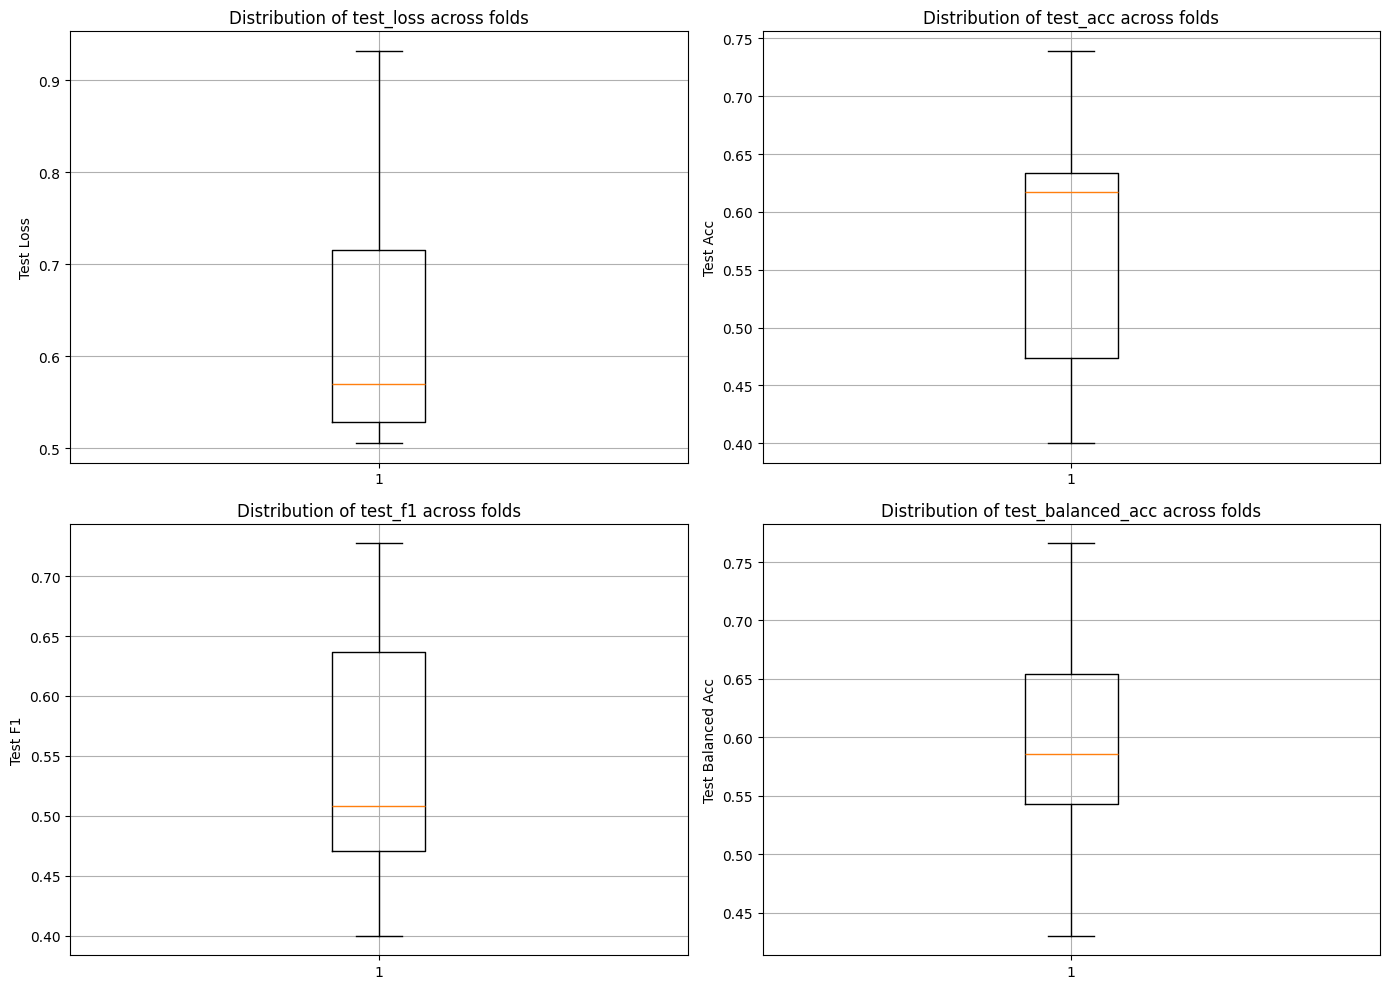

In [ ]:
from utils.mlflow_functions import log_SSL_run_to_mlflow

# Now, call the logging function:
train_transforms, val_transforms, test_transforms = experiment.get_current_fold_transforms()

log_SSL_run_to_mlflow(
    environmentFlags=environment_flags,
    cfg=experiment.cfg,
    model=model_instance_for_logging,
    class_names=experiment.class_names,
    fold_results=outer_fold_test_results,
    per_fold_metrics=per_fold_training_metrics,
    hold_out_cv=hold_out_cv, # Or experiment.cfg.path.to.hold_out_flag
    test_transforms=val_transforms,
    all_images_paths_np=images_paths_np, # Paths from the DF used in CV
    all_labels_np=experiment.labels_np, # Labels corresponding to all_images_paths_np from CV
    test_images_paths_np=test_images_paths_np, # Assuming this is a SEPARATE hold-out set
    test_true_labels_np=test_true_labels_np,   # Labels for the SEPARATE hold-out set
    yaml_path=yaml_path,
    color_transforms=color_transforms, # Or experiment.cfg.path.to.color_transforms
    model_library=model_library,       # Or experiment.cfg.path.to.model_library
    # encoder_type="none", # If these become active, source them from experiment.cfg
    # pretrained_backbone_path = "none",
)

In [ ]:
import datetime
from utils.directory_functions import get_tracking_uri, get_base_directory
# from utils.test_functions import evaluate_model
# from utils.data_visualization_functions import plot_learning_curves, plot_confusion_matrix
from utils.vit_explanation_functions import save_attention_overlays_side_by_side
from utils.mlflow_functions import *
# from utils.mlflow_functions import log_folds_results_to_csv, log_kfold_epoch_metrics

tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)

run_name = create_run_name(cfg, pretrained_weights, color_transforms, model_library)

print(f"Current tracking uri: {tracking_uri}")
print(cfg.get_freezed_layer_index())
# Start your components list with the model name

print_layers(model)
#print("experiment_name:",experiment_name)

# Example usage:
target_layer, target_layer_type = find_last_conv_layer(model)
print("Target layer:", target_layer)
print("Target layer type:", type(target_layer_type))

 #input("Enter the layer name to visualize the activations: ")

num_input_channels = cfg.get_model_input_channels()

if len(class_names) == 2:
    experiment_name = f"{class0_name}_vs_{class1_name}_{num_input_channels}channels_fixed_dataset"
else:
    class0_names,class1_names,class2_names = class_names
    experiment_name = f"{class0_names}_vs_{class1_names}_vs_{class2_names}_{num_input_channels}channels_fixed_dataset"
    
mlflow.set_experiment(experiment_name)  # Replace (ctrl_vs_MSA_classifier or msap_vs_msac_classifier or ctrl_vs_MSA_classifier_3c)
with mlflow.start_run(run_name=run_name):
    # Log parameters
    # mlflow.log_params(cfg.data_splitting)
    # mlflow.log_params(cfg.data_augmentation)
    # mlflow.log_params(cfg.data_loading)
    # mlflow.log_params(cfg.model)
    # #mlflow.log_params(cfg.training)
    # mlflow.log_params(cfg.optimizer)
    mlflow.log_param("freezed_layer_index", cfg.get_freezed_layer_index())
    mlflow.log_param("color_transforms", color_transforms)
    mlflow.log_param("num_epochs", cfg.training["num_epochs"])
    mlflow.log_param("early_stopping_patience", cfg.training["early_stopping_patience"])
    mlflow.log_param("mixup_alpha", cfg.training["mixup_alpha"])
    mlflow.log_param("oversample", cfg.training["oversample"])
    mlflow.log_param("undersample", cfg.training["undersample"])
    mlflow.log_param("weighted_loss", cfg.training["weighted_loss"])
    mlflow.log_param("fine_tuning", cfg.training["fine_tuning"])
    mlflow.log_param("transfer_learning", cfg.training["transfer_learning"])
    mlflow.log_param("pretrained", cfg.training["pretrained"])
    mlflow.log_param("weight_decay", cfg.get_weight_decay())
    mlflow.log_param("dropout_rate", cfg.get_dropout_prob())
    mlflow.log_param("outer_test_size", outer_test_size)
    mlflow.log_param("outer_train_size", outer_train_size)
    mlflow.log_param("internal_train_size", internal_train_size)
    mlflow.log_param("internal_val_size", internal_val_size)
    mlflow.log_param("total parameters", sum(p.numel() for p in model.parameters()))
    mlflow.log_param("trainable parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    # Log metrics for each epoch
    # for epoch in range(len(train_losses)):  # Iterate up to the length of the lists
    #     mlflow.log_metric("train_loss", train_losses[epoch], step=epoch)
    #     mlflow.log_metric("train_accuracy", train_accuracies[epoch], step=epoch)
    #     mlflow.log_metric("val_loss", val_losses[epoch], step=epoch)
    #     mlflow.log_metric("val_accuracy", val_accuracies[epoch], step=epoch)
    #     mlflow.log_metric("val_f1", val_f1_scores[epoch], step=epoch)
    #     mlflow.log_metric("val_balanced_accuracy", val_balanced_accuracies[epoch], step=epoch)
    
    log_kfold_epoch_metrics(per_fold_metrics, prefix="test")

        # mlflow.log_metric("auc", val_aucs[epoch], step=epoch)
    # Log final metrics
    try:
        fold_results
    except NameError:
        fold_results = None
    if fold_results is not None:
        # log_fold_results_metrics(fold_results, prefix='val')  
        log_folds_results_to_csv(fold_results, prefix='val')
        # Check if fig exists before logging it

    #mlflow.log_figure(box_plots_fig, "fold_results.png") #save folds box plots
    # Log the Model
    mlflow.pytorch.log_model(model, "model")

    # Log the Notebook
    base_dir = get_base_directory(gdrive, kaggle,linux)
    if gdrive:
        mlflow.log_artifact("/content/drive/MyDrive/TESI/TESI/notebooks/CNN_classifier.ipynb", artifact_path="notebooks")
    elif kaggle:
        print("you are on kaggle skip saving ipynb")
        #mlflow.log_artifact("/kaggle/working//MIP_classifier_Official.ipynb")
    else:
        mlflow.log_artifact(rf"{base_dir}/notebooks/CNN_classifier.ipynb")

    mlflow.log_figure(fold_box_plot_fig, "fold_box_plots.png")
    # Evaluate on the test set
    
    if hold_out_cv:
        mlflow.log_metric("mean_test_accuracy", mean_test_acc)
        mlflow.log_metric("mean_test_f1", mean_test_f1)
        mlflow.log_metric("mean_test_balanced_accuracy", mean_test_balanced_acc)
        mlflow.log_metric("mean_test_precision", mean_test_precision)
        mlflow.log_metric("mean_test_recall", mean_test_recall)
        
    if cfg.model["model_name"].lower() == "vit":
        
        import shutil
        
        all_data = [{"image": img, "label": lbl} for img, lbl in zip(images_paths_np, labels_np)]
        all_dataset = Dataset(data=all_data, transform=val_transforms)
        all_data_loader = DataLoader(
            all_dataset,
            batch_size=4,
            shuffle=False,
            num_workers=0
        )
        
        all_data_activations_loader_path = "activations_overlays_all"
        save_attention_overlays_side_by_side(all_data_loader, model, all_data_activations_loader_path, device,overlay_alpha=0.5)
        mlflow.log_artifacts(all_data_activations_loader_path, artifact_path="activation_overlays_all")
        shutil.rmtree(all_data_activations_loader_path)
        
        activation_overlay_output_path = "activation_overlays"
        save_attention_overlays_side_by_side(test_loader, model, activation_overlay_output_path, device, overlay_alpha=0.5)
        mlflow.log_artifacts(activation_overlay_output_path, artifact_path="activation_overlays_test")

        # Delete the local directory after logging to MLflow
        shutil.rmtree(activation_overlay_output_path)
        
        
    from utils.explainability_functions import generate_and_save_gradcam_batch
    # Or GradCAM++
    try:
        gradcampp = GradCAMpp(
            nn_module=model,
            target_layers=[target_layer],
            register_backward=True
        )
    except Exception as e:
        print("no gradcam can be defined over this model")
    #------- saving test images gradcams -------------------------------
    #Call the function with your chosen GradCAM variant
    try: 
        gradcam_folder = generate_and_save_gradcam_batch(
            model=model,
            loader=test_loader,
            gradcam_obj=gradcampp,  # or gradcampp
            output_dir=base_dir,
            class_names=class_names,
            run_name=run_name,
            experiment_name=experiment_name
        )
        mlflow.log_artifacts(gradcam_folder, artifact_path="test_gradcam_images")
    except Exception as e:
        print(f"Error generating GradCAM for test images: {e}")
        
    # #------------------- saving gradcams of misclassified images --------------------------
    misclassified_data = [{"image": img, "label": lbl} for img, lbl in zip(misclassified_images, misclassified_true_labels)]
    misclassified_dataset = Dataset(data=misclassified_data) # i dont pass transform here because the misclassified_data already has the images transformed see implementation of misclassified images
    # of dataLoader passed to eval_model
    misclassified_loader = DataLoader(
        misclassified_dataset,
        batch_size=cfg.get_batch_size(),
        shuffle=False,
        num_workers=cfg.get_num_workers()
    )

    print("Generating GradCAM for misclassified images")
    
    try:
        misclassified_folder = generate_and_save_gradcam_batch(
            model=model,
            loader=misclassified_loader,
            gradcam_obj=gradcampp,  # or gradcampp
            output_dir=os.path.join(base_dir,"misclassified"),
            class_names=class_names,
            run_name=run_name,
            experiment_name=experiment_name
        )
        mlflow.log_artifacts(misclassified_folder, artifact_path="misclassified_gradcam_images")
           
    except Exception as e:
        print(f"Error generating GradCAM for misclassified images: {e}")
    
    # # ----------------- saving gradcams with trashold ---------------------
    from utils.explainability_functions import process_and_save_batch_gradcam_and_Overlay
    from utils.data_visualization_functions import min_max_normalization
    # Initialize GradCAM object
    # Call the function to process and save Grad-CAM++ visualizations
    try:
        thrasholded_gradcam_folder = process_and_save_batch_gradcam_and_Overlay(
            model=model,
            test_loader=test_loader,
            gradcam_obj=gradcampp,
            base_dir=base_dir,
            class_names = class_names,
            min_max_rescale_for_display=min_max_normalization,
            threshold=0.0,
            run_name=run_name,
            experiment_name=experiment_name
        )
        mlflow.log_artifacts(thrasholded_gradcam_folder, artifact_path="gradcam_images_with_threshold")
    except Exception as e:
        print(f"Error generating GradCAM with threshold: {e}")
    
    #-------------- log yaml file with all the parameters -------------------
    import yaml
    mlflow.log_artifact(yaml_path, "config")
    
    mlflow.log_artifacts(cm_dir, artifact_path="confusion_matrices")
    mlflow.log_artifact(learning_dir, artifact_path="learning_curves")
    # Also log the YAML content as parameters for easier querying
    with open(yaml_path) as f:
        yaml_config = yaml.safe_load(f)
    
    # Log each section with a prefix for better organization
    for section, params in yaml_config.items():
        if isinstance(params, dict):
            mlflow.log_params({f"{section}.{k}": v for k, v in params.items()})
    
    #log the transformations and model setup functions code
    mlflow.log_artifact("/home/zano/Documents/TESI/TESI/utils/transformations_functions.py", "transform_params")
    # mlflow.log_artifact("/home/zano/Documents/TESI/TESI/utils/setup_model.py", "model_setup")
    
cfg.set_freezed_layer_index(None) #reset the frozen layer index so that it gets asked again when rerunning this cell

Traceback (most recent call last):
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zano/Documents/TESI/TESI/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1361, in _read_helper
    result =

you are on linux
Run name: Resnet18_oversamp_TL_pretrained:imagenet_torchvision_color_transforms:False_05-10_at:16-40-51
Current tracking uri: /home/zano/Documents/TESI/mlruns
None

conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu
layer3.1.conv2
layer3.1.bn2
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
layer4.1
layer4.1.conv

NameError: name 'outer_test_size' is not defined

## visualize mlflow ui locally

In [ ]:
#!TODO you implemented get_tracking_uri in directory_functions.py possible conflict
from utils.mlflow_functions import start_mlflow_ui
from utils.directory_functions import get_tracking_uri,get_base_directory
gdrive = False
tracking_uri = get_tracking_uri(gdrive,kaggle,linux)
mlflow.set_tracking_uri(tracking_uri)
#tracking_uri = get_tracking_uri()
print("Tracking URI:", tracking_uri)

start_mlflow_ui(tracking_uri)

ImportError: cannot import name 'start_mlflow_ui' from 'utils.mlflow_functions' (/home/zano/Documents/TESI/TESI/utils/mlflow_functions.py)

MLflow UI will start on http://127.0.0.1:5000
Open this URL in web browser

to kill all mlflow processes in case of bugs: 
> ps aux | grep mlflow

> pkill -f mlflow

In [ ]:
!ps aux | grep mlflow
!pkill -f mlflow

zano       10043  2.0  0.6 1355360 194860 ?      Sl   12:35   0:02 /home/zano/Documents/TESI/TESI/venv/bin/python /home/zano/Documents/TESI/TESI/venv/bin/mlflow ui --backend-store-uri file:///home/zano/Documents/TESI/TESI/notebooks/mlruns
zano       10067  0.0  0.0  31276 24188 ?        S    12:35   0:00 /home/zano/Documents/TESI/TESI/venv/bin/python -m gunicorn -b 127.0.0.1:5000 -w 4 mlflow.server:app
zano       10068  1.6  0.6 1354444 191660 ?      Sl   12:35   0:01 /home/zano/Documents/TESI/TESI/venv/bin/python -m gunicorn -b 127.0.0.1:5000 -w 4 mlflow.server:app
zano       10069  1.7  0.5 1354272 191544 ?      Sl   12:35   0:01 /home/zano/Documents/TESI/TESI/venv/bin/python -m gunicorn -b 127.0.0.1:5000 -w 4 mlflow.server:app
zano       10070  1.4  0.5 1354272 191152 ?      Sl   12:35   0:01 /home/zano/Documents/TESI/TESI/venv/bin/python -m gunicorn -b 127.0.0.1:5000 -w 4 mlflow.server:app
zano       10071  1.9  0.5 1353248 191620 ?      Sl   12:35   0:02 /home/zano/Documents/TESI/

## SOLVING CUDA OUT OF MEMORY ERROR

> nvidia-smi

> kill -9 <PID>

## HOW TO FORWARD A PORT TO SEE MLFLOW ##
Using VSCode Remote-SSH Port Forwarding
If you're already using the VSCode Remote-SSH extension, you can also forward ports directly within VSCode:

Connect to Your Remote Machine in VSCode.

Open the Command Palette (Ctrl+Shift+P) and Search for "Remote-SSH: Forward Port from Active Host".

Enter the Port Number (5000).

VSCode Will Create a Local Port Forwarding Rule.

Open Your Browser and Navigate to http://127.0.0.1:5000 to See the MLflow UI.

## colab mlflow tunneling

In [ ]:
!start mlflow ui

In [ ]:
!pip install pyngrok

In [ ]:
# Stop any currently running MLflow UI instances (optional)
#!pkill -f "mlflow ui"
# Restart MLflow UI
!nohup mlflow ui --backend-store-uri "/content/drive/MyDrive/TESI/colab_mlruns_final" --port 5000 > mlflow_log.txt 2>&1 &
!ngrok config add-authtoken 2qRUx4ZxTdpOdFbH7rrUcXVjQQU_7CW2Xt1DQAyfPSKj5upn

In [ ]:
from pyngrok import ngrok

# Connect ngrok to the port on which MLflow UI is running
public_url = ngrok.connect(5000)
public_url #click on the following output links

<NgrokTunnel: "https://907f-34-125-55-230.ngrok-free.app" -> "http://localhost:5000">

# RESULT EXPLAINABILITY

In [ ]:
from utils.data_visualization_functions import visualize_batch_histograms, visualize_batch_boxplots, print_batch_image_statistics
from utils.explainability_functions import *

## helper visualization functions

In [ ]:
# # test_msa_ids = [7144,7120,7239,7293]
# # test_pd_ids = [7155,7222,7229,7284]
# # test_dir = os.path.join(data_dir, "TEST")
# # test_images_paths = list(sorted(glob.glob(os.path.join(test_dir, "*.tif"))))
# print(f"class 0:{class0_name} class 1:{class1_name}")

# def get_label(path):
#     id_num = int(os.path.basename(path).split("_")[0])
#     if id_num in test_msa_ids:
#         return 1
#     elif id_num in test_pd_ids:
#         return 0
#     else:
#         raise ValueError(f"Unknown ID: {id_num}")

# test_true_labels = [get_label(path) for path in test_images_paths]
# #true_test_labels = [1 if int(os.path.basename(path).split("_")[0]) in test_msa_ids 0 for path in test_images_paths]
# test_true_labels = np.array(test_true_labels)
# print(f"Found {len(test_images_paths)} test images.")
# print(test_images_paths)
# print(test_true_labels)

test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, test_true_labels)]
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

example_batch = next(iter(test_loader))
images = example_batch["image"].to(device)
labels = example_batch["label"].to(device)

In [ ]:
visualize_batch_histograms(images, labels,class1_name, class0_name, bins=256)

In [ ]:
visualize_batch_boxplots(images, labels, class1_name, class0_name)

In [ ]:
print_batch_image_statistics(images, labels, class1_name, class0_name)

In [ ]:
from utils.mlflow_functions import (
    get_mlrun_base_folder,
    get_experiment_id_byName,
    get_run_name_by_id,
    print_run_ids_and_names
)
from utils.directory_functions import get_tracking_uri

In [ ]:
# print all the models id and name under the experiment
tracking_uri = get_tracking_uri(gdrive,kaggle,linux)  # Replace with your tracking URI
# from mlflow.tracking import get_tracking_uri
# tracking_uri = get_tracking_uri()
print(f"Tracking URI: {tracking_uri}")
mlflow.set_tracking_uri(tracking_uri)
experiment_name = f"{class0_name}_vs_{class1_name}_classifier"  # Replace with your experiment namef"{class0_name}_vs_{class1_name}_classifier"
experiment_id = get_experiment_id_byName(experiment_name)
print(f"Experiment '{experiment_name}' has ID: {experiment_id}")
print_run_ids_and_names(experiment_name, tracking_uri)

In [ ]:
# 2. Run ID and Artifact Path (same as before)
run_id = input("Enter the run ID you see in the above outputs: ")

model_path = "model"  # Or whatever artifact path you used
base_folder = get_mlrun_base_folder(gdrive,kaggle,linux) #NB change the paths in the implementation of this if needed
print("base folder",base_folder)
# 3. Local path to the downloaded artifact directory
local_artifact_path = os.path.join(base_folder, experiment_id, run_id) # use the exact folder path on you computer
test = os.path.join(local_artifact_path, "artifacts", model_path)
#print("test path",test)
normalize_path = os.path.normpath(test)
#print("normalized path",normalize_path)
# 4. Load the model using the local path
if os.path.exists(normalize_path): # this mean it was created under an artifact directory
    model = mlflow.pytorch.load_model(os.path.join(local_artifact_path, "artifacts", model_path), map_location=torch.device('cpu'))
else: # we have to deal with the empty path case
    print("using empty path")
    model = mlflow.pytorch.load_model(local_artifact_path, artifact_path= model_path, map_location=torch.device('cpu')) # pass a valid artifact path

# 5. (Optional) Prepare for inference
device = get_device()
model = model.to(device)
model.eval()

run_name = get_run_name_by_id(run_id,tracking_uri,experiment_id)
# 6. (Optional) Test loading
print(f"Model {run_name} Loaded successfully")


Test Set Metrics:
Test Accuracy: 0.3125
Test F1 Score: 0.0000
Test Balanced Accuracy: 0.3125

Confusion Matrix:
 [[5 3]
 [8 0]]


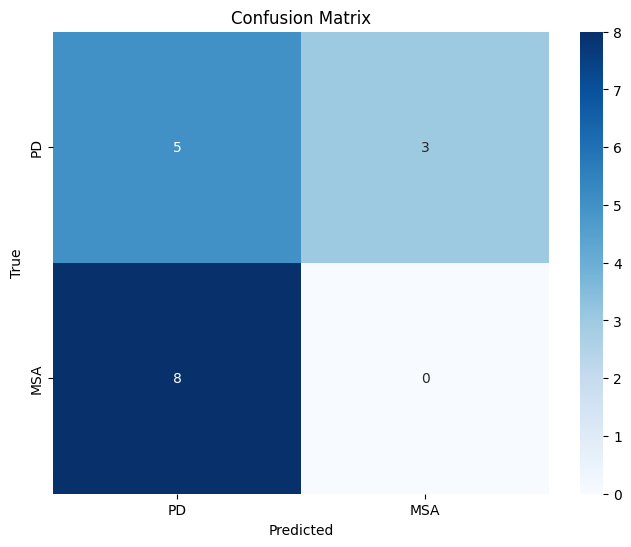

In [ ]:
# -------------------------------------------------------------------------
# STEP 6 : Evaluate on test set
# -------------------------------------------------------------------------
# 6.1 - Create the test Dataset and DataLoader
test_data = [{"image": img, "label": lbl} for img, lbl in zip(test_images_paths, test_true_labels)]
test_transforms = val_transforms
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

# 6.3 - Inference on the test set
y_true, y_pred = [], []
misclassified_images = []  # Store misclassified image data and info
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        images_batch, labels_batch = batch["image"].to(device), batch["label"].to(device).long()
        outputs = model(images_batch)
        _, predicted = torch.max(outputs, dim=1)
        y_true.extend(labels_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # Find misclassifications in the current batch
        batch_true = labels_batch.cpu().numpy()
        batch_pred = predicted.cpu().numpy()
        batch_images = images_batch.cpu().numpy()

        misclassified_indices = np.where(batch_true != batch_pred)[0]

        for i in misclassified_indices:
            misclassified_images.append({
                "image": batch_images[i],
                "true_label": batch_true[i],
                "pred_label": batch_pred[i],
                "batch_index": batch_idx  # For context if needed
            })

# 6.4 - Compute test metrics including balanced accuracy
test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='binary')
test_balanced_acc = balanced_accuracy_score(y_true, y_pred)

# 6.5 - Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nTest Set Metrics:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[class0_name, class1_name],  # or your class names
    yticklabels=[class0_name, class1_name]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## GRAD CAM

In [ ]:
print_layers(model)


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.layers
features.denseblock1.denselayer1.layers.norm1
features.denseblock1.denselayer1.layers.relu1
features.denseblock1.denselayer1.layers.conv1
features.denseblock1.denselayer1.layers.norm2
features.denseblock1.denselayer1.layers.relu2
features.denseblock1.denselayer1.layers.conv2
features.denseblock1.denselayer1.layers.dropout
features.denseblock1.denselayer2
features.denseblock1.denselayer2.layers
features.denseblock1.denselayer2.layers.norm1
features.denseblock1.denselayer2.layers.relu1
features.denseblock1.denselayer2.layers.conv1
features.denseblock1.denselayer2.layers.norm2
features.denseblock1.denselayer2.layers.relu2
features.denseblock1.denselayer2.layers.conv2
features.denseblock1.denselayer2.layers.dropout
features.denseblock1.denselayer3
features.denseblock1.denselayer3.layers
features.denseblock1.denselayer3.layers.no

In [ ]:
# Example for MONAI ViT:
target_layer = input("Enter the target layer name: ")
#target_layer = "blocks.3.attn.output"
# Initialize GradCAM
gradcam = GradCAM(
    nn_module=model,
    target_layers=[target_layer],
)

visualize_gradcam_for_single_image(model,test_loader, gradcam, min_max_normalization)

NameError: name 'visualize_gradcam_for_single_image' is not defined

single image shape: torch.Size([1, 3, 512, 512])
gradcam shape torch.Size([1, 1, 512, 512])


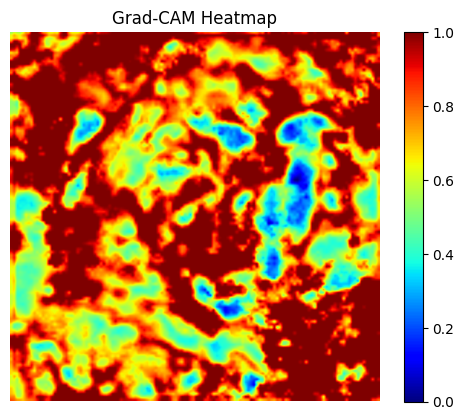

In [ ]:
## example with one image and one label
target_layer = input("insert the target layer name for gradcam, usually the last conv layer: ")

gradcam = GradCAM(
    nn_module=model,             # your trained model
    target_layers=[target_layer],  # the layer you've chosen
    # optional: set relu=True to ensure ReLU is applied before computing GradCAM
)

model.eval()

# Suppose you just take the first batch from your val_loader or test_loader:
example_batch = next(iter(test_loader))
images = example_batch["image"].to(device)  # shape: (B, C, H, W) for 2D images
labels = example_batch["label"].to(device)  # shape: (B,)

# Let's pick the first image from the batch
single_image = images[0].unsqueeze(0)  # shape: unsqueeze add the first 1 to the dimension which now is (1, C, H, W)
print(f"single image shape:", single_image.shape) #torch.Size([1, 3, 256, 256])
single_label = labels[0].unsqueeze(0) # shape: (1, 1, H, W) for 2D images
#the before unsqueeze are done since gradcam works with 4D tensors
cam_tensor = gradcam(x=single_image) # shape: (B, C, H, W) for 2D images = ([8, 1, 512, 512])
print("gradcam shape", cam_tensor.shape) #torch.Size([1, 1, 256, 256])
cam_np = cam_tensor.squeeze().cpu().numpy()  #squeeze removes dimensions of size=1 new shape: (H, W)

plt.imshow(cam_np, cmap="jet")
plt.colorbar()
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()

In [ ]:
from utils.explainability_functions import generate_and_save_gradcam_batch
# Or GradCAM++
gradcampp = GradCAMpp(
    nn_module=model,
    target_layers=[target_layer],
    register_backward=True
)

# Call the function with your chosen GradCAM variant
generate_and_save_gradcam_batch(
    model=model,
    loader=test_loader,
    gradcam_obj=gradcampp,  # or gradcampp
    output_dir=base_dir,
    class1_name=class1_name,
    class0_name=class0_name,
    run_name=run_name,
    experiment_name=experiment_name
)

# Visualize GradCAM for misclassified images

Saving gradcam visualizations to: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp
Processing batch 1, shape: torch.Size([8, 3, 512, 512])
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_0.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_1.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_2.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_3.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_4.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_5.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/gradcam_outputs/Simple

In [ ]:
misclassified_data = [{"image": img, "label": lbl} for img, lbl in zip(misclassified_images, misclassified_true_labels)]
misclassified_dataset = Dataset(data=misclassified_data) # i dont pass transform here because the misclassified_data already has the images transformed see implementation
# of dataLoader passed to eval_model
misclassified_loader = DataLoader(
    misclassified_dataset,
    batch_size=cfg.data_loading["batch_size"],
    shuffle=False,
    num_workers=cfg.data_loading["num_workers"]
)

print("Generating GradCAM for misclassified images")
generate_and_save_gradcam_batch(
    model=model,
    loader=misclassified_loader,
    gradcam_obj=gradcam,  # or gradcampp
    output_dir=os.path.join(base_dir,"misclassified"),
    class1_name=class1_name,
    class0_name=class0_name,
    run_name=run_name,
    experiment_name=experiment_name
)

Generating GradCAM for misclassified images
Saving gradcam visualizations to: /home/zano/Documents/TESI/TESI/misclassified/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp
Processing batch 1, shape: torch.Size([8, 3, 512, 512])
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/misclassified/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_0.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/misclassified/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_1.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/misclassified/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_2.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/misclassified/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_3.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/misclassified/gradcam_outputs/SimpleMONAICNN_oversamp_S_NN_NT_hyp/batch_0_img_4.png
Saved Grad-CAM overlay: /home/zano/Documents/TESI/TESI/misclassified/gradc

## GRAD CAM ++

In [ ]:
base_dir = get_base_directory(kaggle,gdrive,linux)
print(base_dir)

/home/zano/Documents/TESI/TESI


Images batch shape: torch.Size([8, 3, 512, 512])
GradCAM output shape: torch.Size([1, 1, 512, 512])
GradCAM output shape after squeeze: (512, 512)
Original Heatmap Overlay:


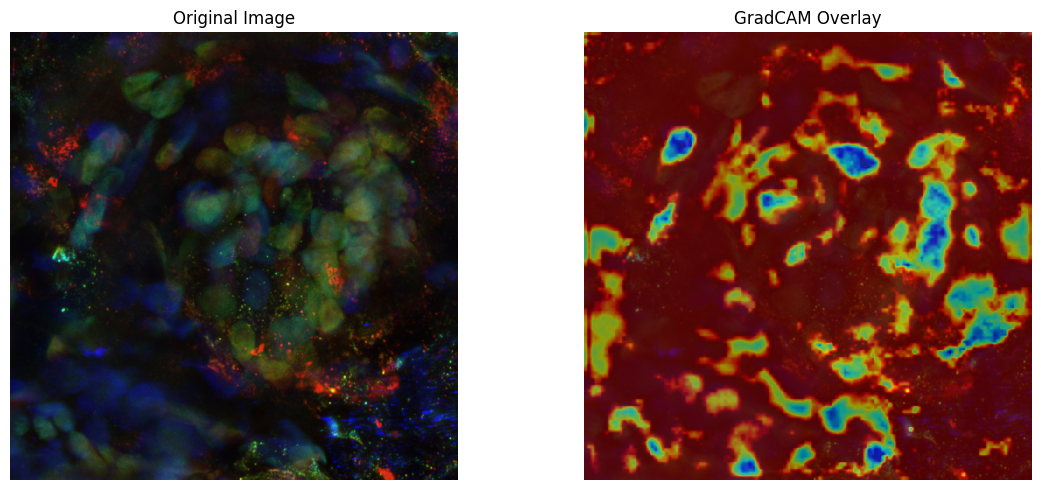

Thresholded(0.8) Heatmap Overlay:


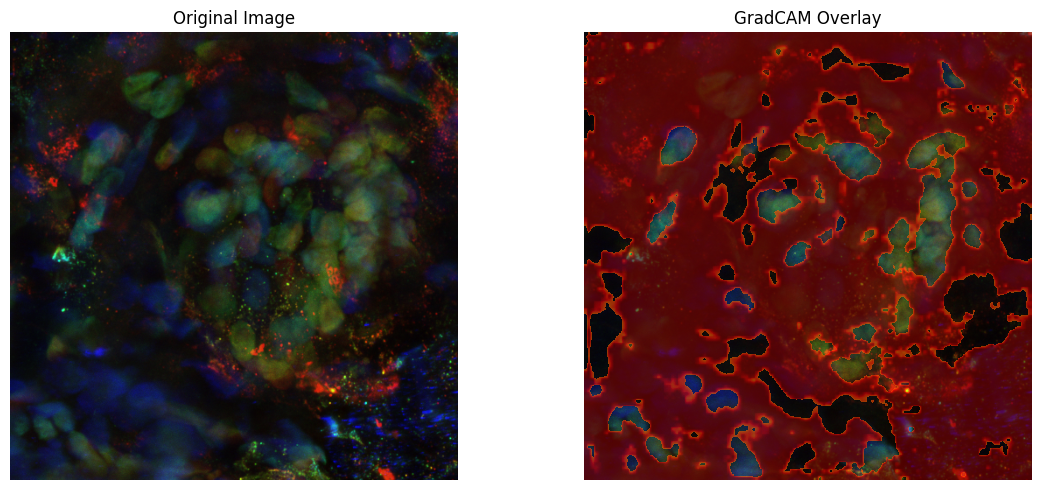

In [ ]:
from monai.visualize import GradCAMpp
from utils.data_visualization_functions import min_max_normalization

# Initialize GradCAM++ object
gradcampp = GradCAMpp(
    nn_module=model,
    target_layers=[target_layer],
    register_backward=True
)

# Or initialize regular GradCAM object
gradcam = GradCAM(
    nn_module=model,
    target_layers=[target_layer],
    register_backward=True
)

# Use either one
visualize_gradcam_for_single_image(model, test_loader, gradcampp, min_max_normalization,threshold =0.8)
# or
#visualize_gradcam_for_single_image(model, test_loader, gradcam, min_max_normalization, threshold=0.8)

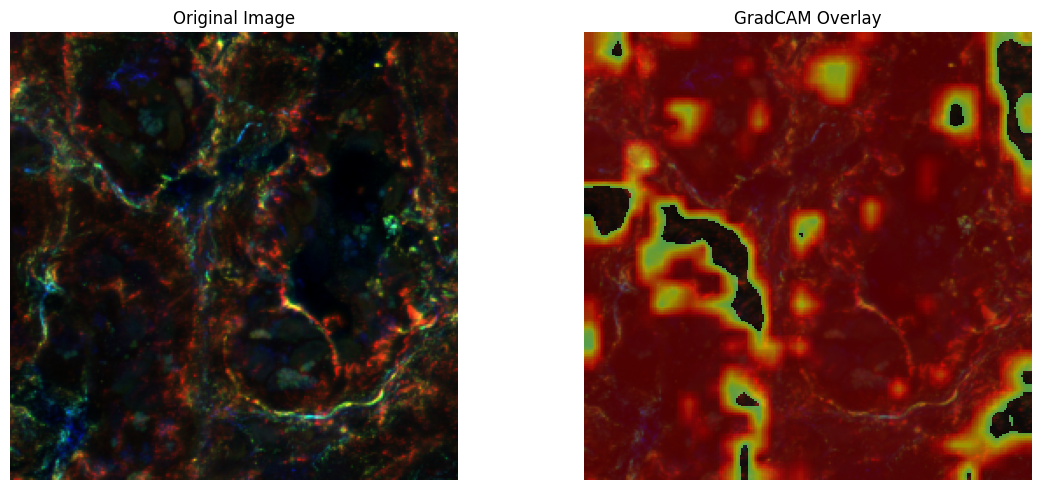

Saved GRADCAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\SimpleCNN_oversamp_S_NN_NT\threshold\batch_0_img_0.png


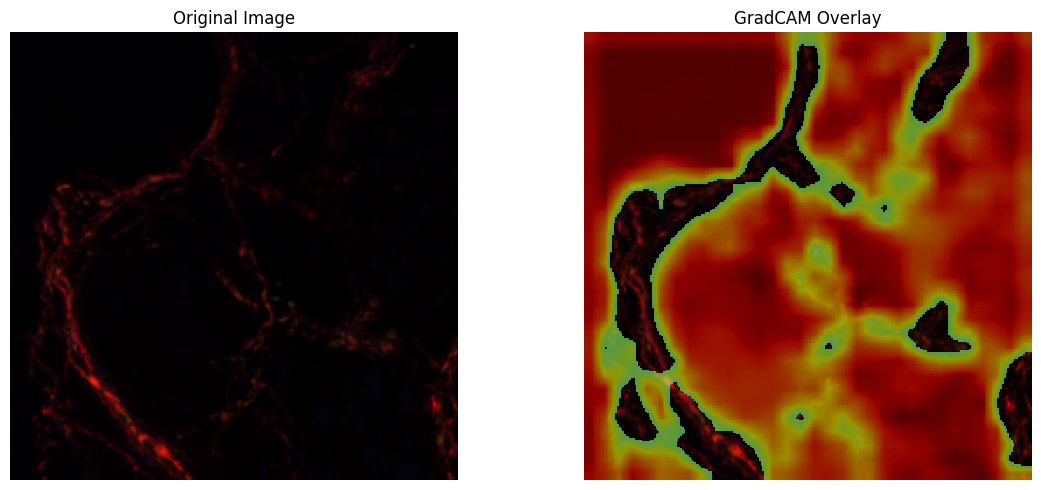

Saved GRADCAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\SimpleCNN_oversamp_S_NN_NT\threshold\batch_0_img_1.png


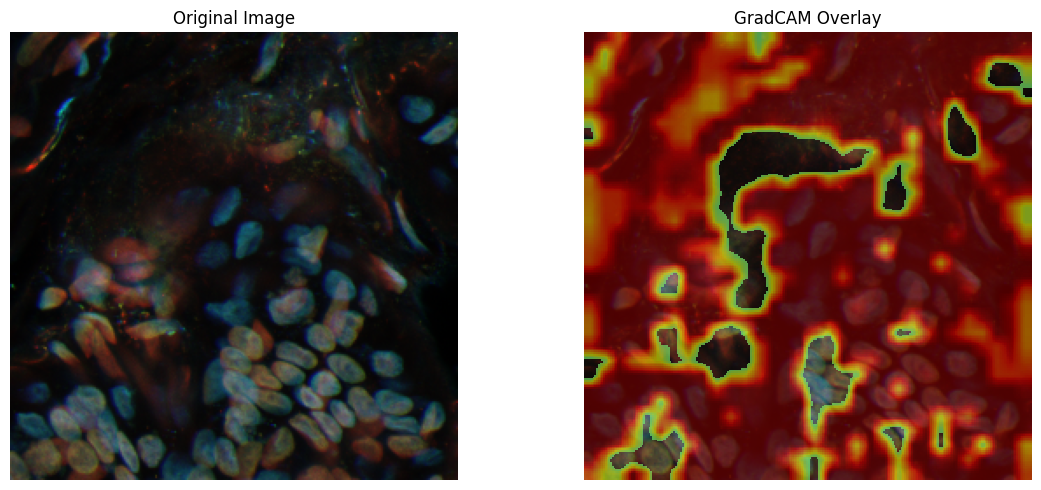

Saved GRADCAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\SimpleCNN_oversamp_S_NN_NT\threshold\batch_0_img_2.png


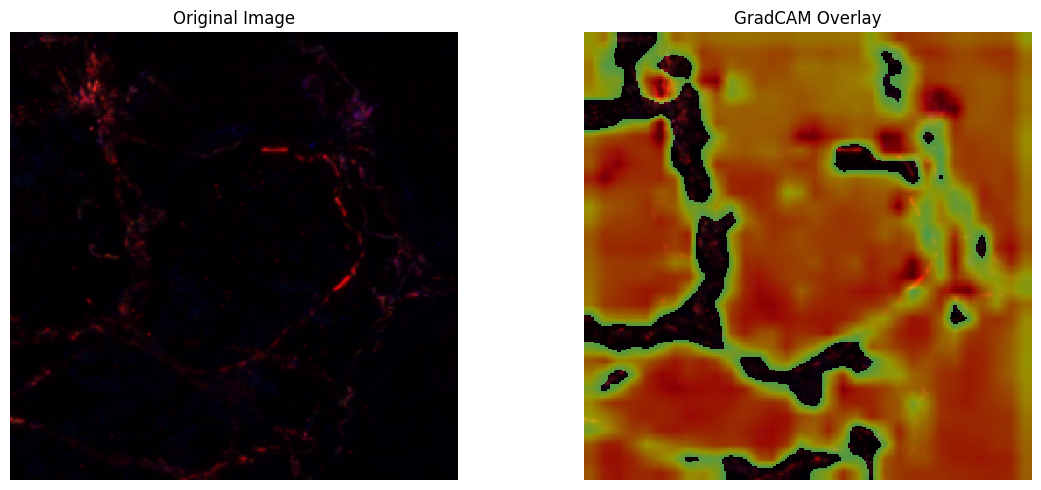

Saved GRADCAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\SimpleCNN_oversamp_S_NN_NT\threshold\batch_0_img_3.png


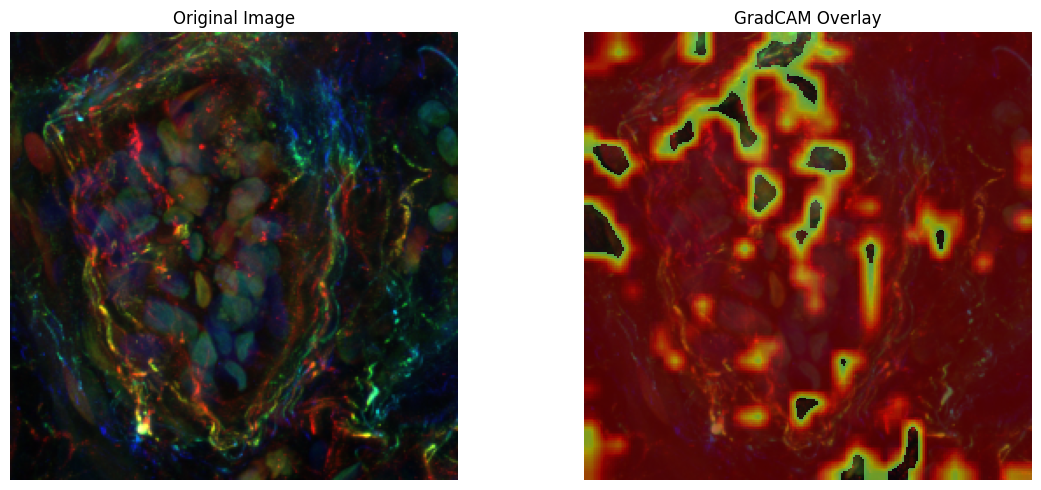

Saved GRADCAM overlay: C:\Users\lucaz\Desktop\TESI\gradcam_outputs\SimpleCNN_oversamp_S_NN_NT\threshold\batch_0_img_4.png


In [ ]:
def process_and_save_gradcampp_batch(
    model,
    test_loader,
    target_layer,
    base_dir,
    min_max_rescale_for_display,
    extract_labels_meaning,
    threshold=0.5
):
    """
    Processes a DataLoader, generates Grad-CAM++ for each image, and saves visualizations.
    Includes both original and thresholded overlays.

    Args:
        model: The PyTorch model.
        test_loader: The DataLoader for the dataset.
        target_layer: The target layer for Grad-CAM (string).
        base_dir: The base directory to save output.
        min_max_rescale_for_display: Function for min-max rescaling.
        extract_labels_meaning: Function for extracting label meanings.
        threshold: Threshold value for heatmap thresholding (default is 0.5).
    """
    # Initialize GradCAM++
    gradcampp = GradCAMpp(
        nn_module=model,
        target_layers=[target_layer],
        register_backward=True
    )

    # Get device from model
    device = next(model.parameters()).device
    model.eval()

    # Create output directory with GradCAM variant in the path
    output_dir = os.path.join(base_dir, "gradcam++_outputs",
                             run_name if run_name else experiment_name)
    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, batch_data in enumerate(test_loader):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        for i in range(images.shape[0]):
            single_image = images[i].unsqueeze(0)
            single_label = labels[i].unsqueeze(0)

            # Get label meaning
            image_label = extract_labels_meaning([single_label.item()],
                                              class1_name,
                                              class0_name)

            # Generate GradCAM++ heatmap
            cam_result = gradcampp(x=single_image, class_idx=1)
            cam_tensor = cam_result.squeeze(0).squeeze(0).cpu().numpy()

            # Process image and apply thresholding
            input_image_np = single_image.squeeze(0).cpu().numpy()
            input_image_np = np.transpose(input_image_np, (1, 2, 0))
            input_image_np = min_max_rescale_for_display(input_image_np)

            # Use existing functions for normalization and thresholding
            cam_normalized = min_max_normalization(cam_tensor)
            cam_thresholded = threshold_heatmap(cam_tensor,
                                              threshold=threshold,
                                              normalize=True)

            # Create visualization
            fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

            # Original Image
            axarr[0].imshow(input_image_np)
            axarr[0].set_title(f"Original Image (Label: {image_label})")
            axarr[0].axis('off')

            # Normalized Overlay
            axarr[1].imshow(input_image_np)
            axarr[1].imshow(cam_normalized, cmap="jet", alpha=0.5)
            axarr[1].set_title("Grad-CAM++ Overlay (Normalized)")
            axarr[1].axis('off')

            # Thresholded Overlay
            axarr[2].imshow(input_image_np)
            axarr[2].imshow(cam_thresholded, cmap="jet", alpha=0.5)
            axarr[2].set_title(f"Grad-CAM++ Overlay (Thresholded, t={threshold})")
            axarr[2].axis('off')

            plt.tight_layout()

            # Save visualization
            save_path = os.path.join(output_dir, "threshold", f"batch_{batch_idx}_img_{i}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            plt.close(fig)

            print(f"Saved Grad-CAM++ overlay: {save_path}")

from utils.explainability_functions import process_and_save_batch_gradcam_and_Overlay
# Initialize GradCAM object
gradcam = GradCAM(
    nn_module=model,
    target_layers=[target_layer],
    register_backward=True
)
# Call the function to process and save Grad-CAM++ visualizations
process_and_save_batch_gradcam_and_Overlay(
    model=model,
    test_loader=test_loader,
    gradcam_obj=gradcam,
    base_dir=base_dir,
    class1_name=class1_name,
    class0_name=class0_name,
    min_max_rescale_for_display=min_max_normalization,
    threshold=0.5,
    run_name=run_name,
    experiment_name=experiment_name
)

In [ ]:
def process_and_save_gradcam_comparison(model, test_loader, target_layer, base_dir, min_max_rescale_for_display, extract_labels_meaning):
    """
    Processes a DataLoader, generates Grad-CAM and Grad-CAM++ overlays for each image, and saves visualizations.

    Args:
        model: The PyTorch model.
        test_loader: The DataLoader for the dataset.
        target_layer: The target layer for Grad-CAM (string).
        base_dir: The base directory to save output.
        min_max_rescale_for_display: A function for min-max rescaling an image or numpy array.
        extract_labels_meaning: A function for extracting the meaning of labels (optional).
    """

    device = next(model.parameters()).device
    model.eval()

    gradcampp = GradCAMpp(
        nn_module=model,
        target_layers=[target_layer],
        register_backward=True
    )

    gradcam = GradCAM(
        nn_module=model,
        target_layers=[target_layer],
        register_backward=True
    )

    output_dir = os.path.join(base_dir, "comparison_gradcam_outputs", run_name if run_name else experiment_name)
    os.makedirs(output_dir, exist_ok=True)

    for batch_idx, batch_data in enumerate(test_loader):
        images = batch_data["image"].to(device)  # (B, C, H, W)
        labels = batch_data["label"].to(device)  # (B,)

        for i in range(images.shape[0]):
            # Select the i-th image and label from the batch
            single_image = images[i].unsqueeze(0)  # (1, C, H, W)
            single_label = labels[i].unsqueeze(0)  # (1,)

            # Get label meaning (if extract_labels_meaning is provided)
            if extract_labels_meaning:
                image_label = extract_labels_meaning([single_label.item()],class1_name,class0_name)
            else:
                image_label = f"Class {single_label.item()}"

            # Compute Grad-CAM and Grad-CAM++ for single image
            cam_result = gradcam(x=single_image, class_idx=1)  # Adjust class_idx if needed
            campp_result = gradcampp(x=single_image, class_idx=1)  # Adjust class_idx if needed

            # Squeeze to (H, W)
            cam_tensor = cam_result.squeeze(0).squeeze(0).cpu().numpy()
            campp_tensor = campp_result.squeeze(0).squeeze(0).cpu().numpy()

            # Convert image to NumPy and transpose to (H, W, C)
            input_image_np = single_image.squeeze(0).cpu().numpy()
            input_image_np = np.transpose(input_image_np, (1, 2, 0))

            # Rescale image and CAMs
            input_image_np = min_max_rescale_for_display(input_image_np)
            cam_normalized = min_max_rescale_for_display(cam_tensor)
            campp_normalized = min_max_rescale_for_display(campp_tensor)

            # Create overlay visualization
            fig, axarr = plt.subplots(1, 3, figsize=(15, 4))

            # Left: original
            axarr[0].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[0].set_title(f"Original Image (Label: {image_label})")
            axarr[0].axis('off')

            # Middle: Grad-CAM overlay
            axarr[1].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[1].imshow(cam_normalized, cmap="jet", alpha=0.5)
            axarr[1].set_title("Grad-CAM Overlay")
            axarr[1].axis('off')

            # Right: Grad-CAM++ overlay
            axarr[2].imshow(input_image_np, cmap='gray' if input_image_np.shape[-1] == 1 else None)
            axarr[2].imshow(campp_normalized, cmap="jet", alpha=0.5)
            axarr[2].set_title("Grad-CAM++ Overlay")
            axarr[2].axis('off')

            plt.tight_layout()

            # Save as PNG
            save_path = os.path.join(output_dir, f"batch_{batch_idx}_img_{i}.png")
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            plt.close(fig)

            print(f"Saved Grad-CAM and Grad-CAM++ overlays: {save_path}")

process_and_save_gradcam_comparison(model, test_loader, target_layer, base_dir, min_max_normalization, extract_labels_meaning)

Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_0.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_1.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_2.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_3.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_4.png
Saved Grad-CAM and Grad-CAM++ overlays: C:\Users\lucaz\Desktop\TESI\comparison_gradcam_outputs\DenseNet121_S_Nspec\batch_0_img_5.png


# RESULTS VISUALIZATIONS

In [ ]:
import pandas as pd
import mlflow
from mlflow.tracking import MlflowClient
from utils.directory_functions import get_tracking_uri, get_base_directory

# List of tracking URIs to check (Kaggle removed)
tracking_uris = [
    {"name": "local", "uri": get_tracking_uri(gdrive, kaggle, linux)},
    {"name": "colab", "uri": "file:///C:/Users/lucaz/Desktop/TESI/colab_mlruns_3c"}
]

# First pass: Collect all experiment names from all tracking URIs
all_experiments = set()  # set of unique experiments
for uri_info in tracking_uris:
    try:
        mlflow.set_tracking_uri(uri_info["uri"])
        for exp in mlflow.search_experiments():
            all_experiments.add(exp.name)
    except Exception as e:
        print(f"Couldn't connect to {uri_info['name']} tracking URI: {e}")

# Let user select an experiment
print("\nAvailable experiments:")
for i, name in enumerate(sorted(all_experiments)):
    print(f"{i+1}. {name}")

selected_idx = int(input("\nEnter experiment number: ")) - 1
selected_experiment = sorted(all_experiments)[selected_idx]  # get the experiment name

# Second pass: Get runs from each source for selected experiment
combined_runs_df = pd.DataFrame()
metrics_of_interest = [
    'tags.mlflow.runName',
    #'metrics.test_accuracy',
    # 'metrics.test_recall',
    # 'metrics.test_precision',
    'metrics.mean_test_f1',
    'metrics.mean_test_balanced_accuracy',
    'metrics.mean_test_accuracy',
    # 'metrics.mean_val_balanced_accuracy'
]

for uri_info in tracking_uris:
    try:
        mlflow.set_tracking_uri(uri_info["uri"])
        print(f"\nChecking {uri_info['name'].upper()} tracking URI...")

        experiment = mlflow.get_experiment_by_name(selected_experiment)
        if not experiment:
            print(f"Experiment '{selected_experiment}' not found in {uri_info['name']}")
            continue

        runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        if runs_df.empty:
            print(f"No runs found in {uri_info['name']}")
            continue

        # Print detailed run info for this source
        print(f"Found {len(runs_df)} runs in {uri_info['name']} experiment (ID: {experiment.experiment_id})")
        for _, row in runs_df.iterrows():
            run_name = row.get('tags.mlflow.runName', 'NO_NAME')
            print(f" | Name: {run_name}")

        # Add to combined dataframe
        runs_df = runs_df[metrics_of_interest]
        combined_runs_df = pd.concat([combined_runs_df, runs_df], ignore_index=True)

    except Exception as e:
        print(f"Error processing {uri_info['name']} tracking URI: {e}")

# Process combined results
if not combined_runs_df.empty:
    print("\nCombining results from all sources...")
    combined_runs_df.dropna(subset=metrics_of_interest, inplace=True)
    
    combined_runs_df.drop_duplicates(subset=['tags.mlflow.runName'], keep='first', inplace=True)
    combined_runs_df.sort_values(by="metrics.mean_test_accuracy", ascending=False, inplace=True)

    print(f"\nFinal combined dataset ({len(combined_runs_df)} runs):")
    display(combined_runs_df)
else:
    print("\nNo runs found across all tracking URIs")

you are on linux
⚠️ Couldn't connect to colab tracking URI: [Errno 13] Permission denied: '/C:'

Available experiments:
1. Default
2. PD_vs_MSA-P_classifier
3. PD_vs_MSA-P_classifier_test_true_hyp
4. PD_vs_MSA_classifier
5. PD_vs_MSA_classifier_test_true_hyp

Checking LOCAL tracking URI...
Found 14 runs in local experiment (ID: 818109381054139853)
 | Name: ViT_oversample_fixed
 | Name: DenseNet121_oversamp_TL_pretrained_freeze_263_oversample_fixed
 | Name: DenseNet121_oversamp_oversample_fixed
 | Name: DenseNet169_oversamp_TL_pretrained_freeze_311_oversample_fixed
 | Name: ResNet_oversamp_TL_pretrained_freeze_152_micronet_oversample_fixed
 | Name: DenseNet121_oversamp_TL_pretrained_freeze_263_micronet_oversample_fixed
 | Name: ResNet_oversamp_TL_pretrained_freeze_152_true_test
 | Name: DenseNet169_oversamp_TL_pretrained_freeze_311_true_test
 | Name: DenseNet169_oversamp_TL_pretrained_freeze_505_true_test
 | Name: DenseNet169_oversamp_true_test
 | Name: DenseNet121_oversamp_TL_pretraine

tags.mlflow.runName  metrics.mean_test_f1  \
11  DenseNet121_oversamp_TL_pretrained_freeze_263_...              0.820311   
6   ResNet_oversamp_TL_pretrained_freeze_152_true_...              0.838946   
5   DenseNet121_oversamp_TL_pretrained_freeze_263_...              0.825668   
10  DenseNet121_oversamp_TL_pretrained_freeze_233_...              0.799882   
7   DenseNet169_oversamp_TL_pretrained_freeze_311_...              0.796940   
3   DenseNet169_oversamp_TL_pretrained_freeze_311_...              0.812973   
9                      DenseNet169_oversamp_true_test              0.802305   
13                                ViT_oversamphyp_ALL              0.786910   
0                                ViT_oversample_fixed              0.800577   
2               DenseNet121_oversamp_oversample_fixed              0.776848   
12                     DenseNet121_oversamp_true_test              0.753280   
4   ResNet_oversamp_TL_pretrained_freeze_152_micro...              0.743056   
1   DenseNet121_oversamp_TL_pretrained_freeze_263_...              0.739041   
8   DenseNet169_oversamp_TL_pretrained_freeze_505_...              0.721010   

    metrics.mean_test_balanced_accuracy  metrics.mean_test_accuracy  
11                             0.816919                    0.797222  
6                              0.791919                    0.796528  
5                              0.785606                    0.786806  
10                             0.817172                    0.776389  
7                              0.812121                    0.775000  
3                              0.751010                    0.764583  
9                              0.751010                    0.755556  
13                             0.732323                    0.743750  
0                              0.703788                    0.734028  
2                              0.702273                    0.722222  
12                             0.748990                    0.722222  
4                              0.732323                    0.711111  
1                              0.737879                    0.710417  
8                              0.754040                    0.701389

In [ ]:
combined_runs_df = combined_runs_df[combined_runs_df['tags.mlflow.runName'].str.contains('oversample_fixed')]
combined_runs_df['tags.mlflow.runName'] = combined_runs_df['tags.mlflow.runName'].str.replace('_oversample_fixed','')
combined_runs_df

tags.mlflow.runName  metrics.mean_test_f1  \
5  DenseNet121_oversamp_TL_pretrained_freeze_263_...              0.825668   
3      DenseNet169_oversamp_TL_pretrained_freeze_311              0.812973   
0                                                ViT              0.800577   
2                               DenseNet121_oversamp              0.776848   
4  ResNet_oversamp_TL_pretrained_freeze_152_micronet              0.743056   
1      DenseNet121_oversamp_TL_pretrained_freeze_263              0.739041   

   metrics.mean_test_balanced_accuracy  metrics.mean_test_accuracy  
5                             0.785606                    0.786806  
3                             0.751010                    0.764583  
0                             0.703788                    0.734028  
2                             0.702273                    0.722222  
4                             0.732323                    0.711111  
1                             0.737879                    0.710417

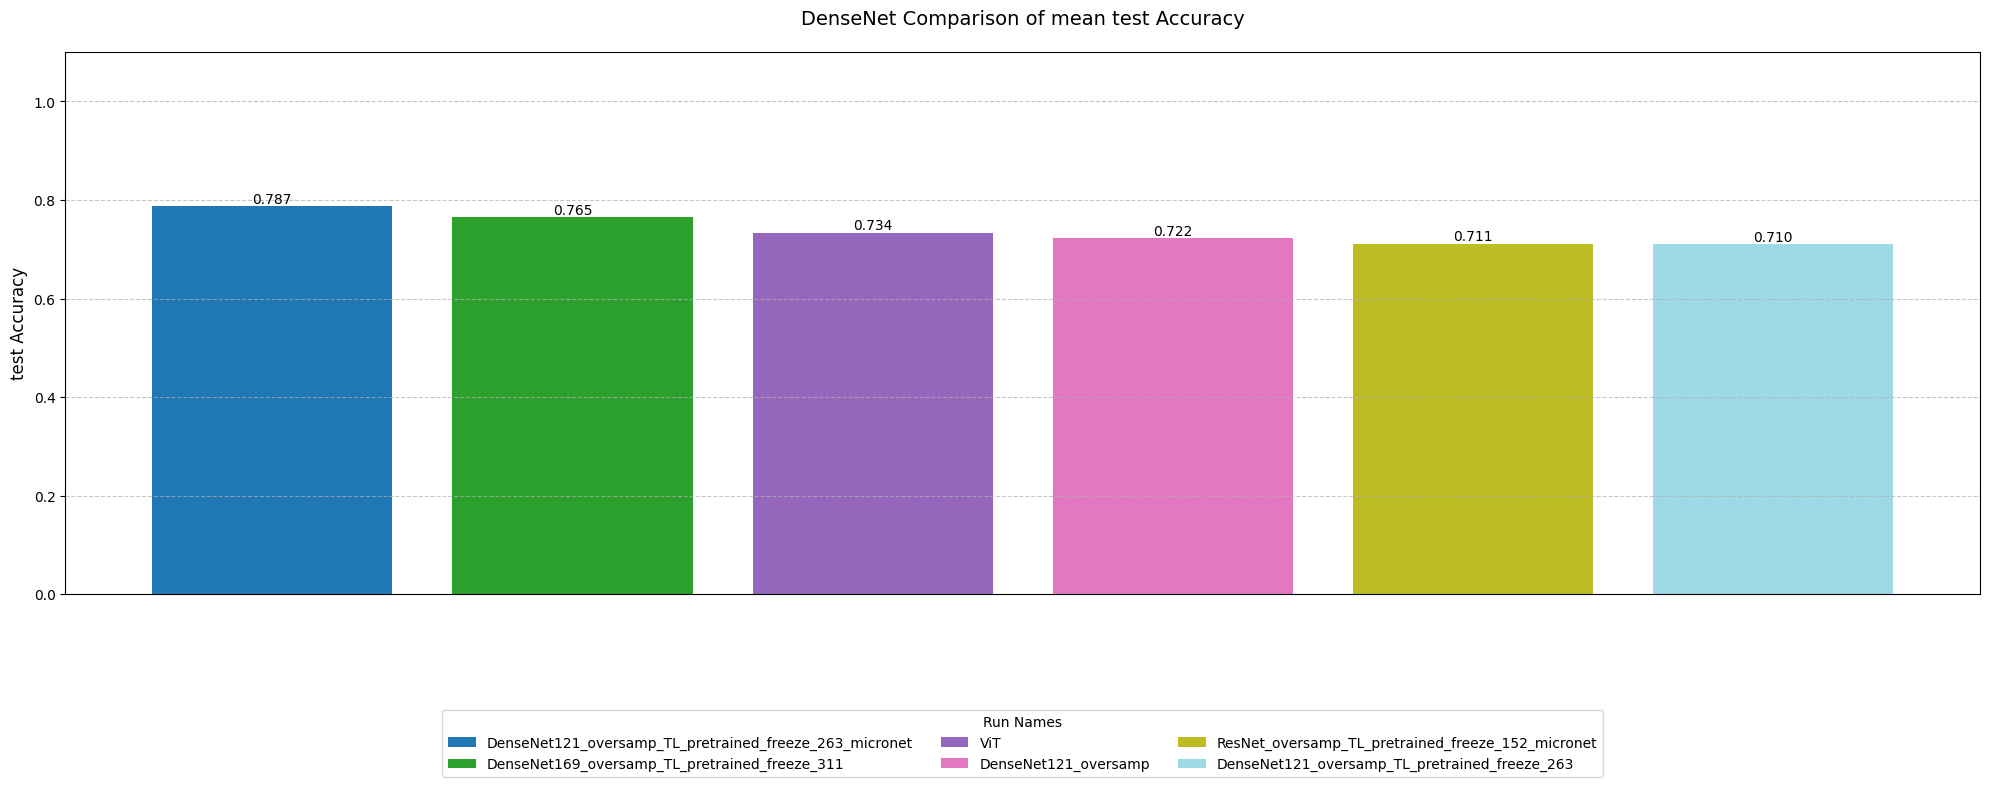

In [ ]:
# 3) Plot a comparison of final validation accuracy across runs (bar plot)
# Create a copy of the run names with "DenseNet_" removed
#combined_runs_df['shortened_name'] = combined_runs_df['tags.mlflow.runName'].str.replace('DenseNet', '')
combined_runs_df['shortened_name'] = combined_runs_df['tags.mlflow.runName']
# Assign unique colors to each run
unique_runs = combined_runs_df['shortened_name'].unique()
num_runs = len(unique_runs)

# Create a custom color palette with more contrasting colors
colors = plt.cm.tab20(np.linspace(0, 1, num_runs))  # 'tab20' has more distinct color steps
# Alternative colormaps you could use: 'Set3', 'Paired', 'Set1', 'Set2'

# Create a dictionary mapping run names to colors
run_color_map = {run: colors[i] for i, run in enumerate(unique_runs)}

# Add color column to DataFrame by mapping runs
combined_runs_df['color'] = combined_runs_df['shortened_name'].map(run_color_map)

# Create the plot with unique colors
plt.figure(figsize=(20, 8))

# Store bar containers for later use
bar_containers = []

# Use the 'color' column to specify bar colors
for run_name, color in run_color_map.items():
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        run_data['shortened_name'],
        run_data['metrics.mean_test_accuracy'],
        color=color,
        label=run_name
    )
    bar_containers.append(container)

# Remove x-axis tick labels
plt.xticks([])

plt.ylim(0, 1.1)
plt.title("DenseNet Comparison of mean test Accuracy", fontsize=14, pad=20)
plt.ylabel("test Accuracy", fontsize=12)

# Add value labels on top of each bar
for container in bar_containers:
    for bar in container:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend below the plot to show the run-color mapping
legend = plt.legend(title="Run Names", bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust bottom spacing to accommodate the legend

plt.show()

NT = no tranformation/augmentation ie flip,Rotate,RandomNoise (inside Compose)
NN = no channel wise normalization (inside Compose)
NS = no scaleIntensityd (inside compose)
NO = no fold oversampling applied
transform(all)=flip+Rotate+RandomNoise applied

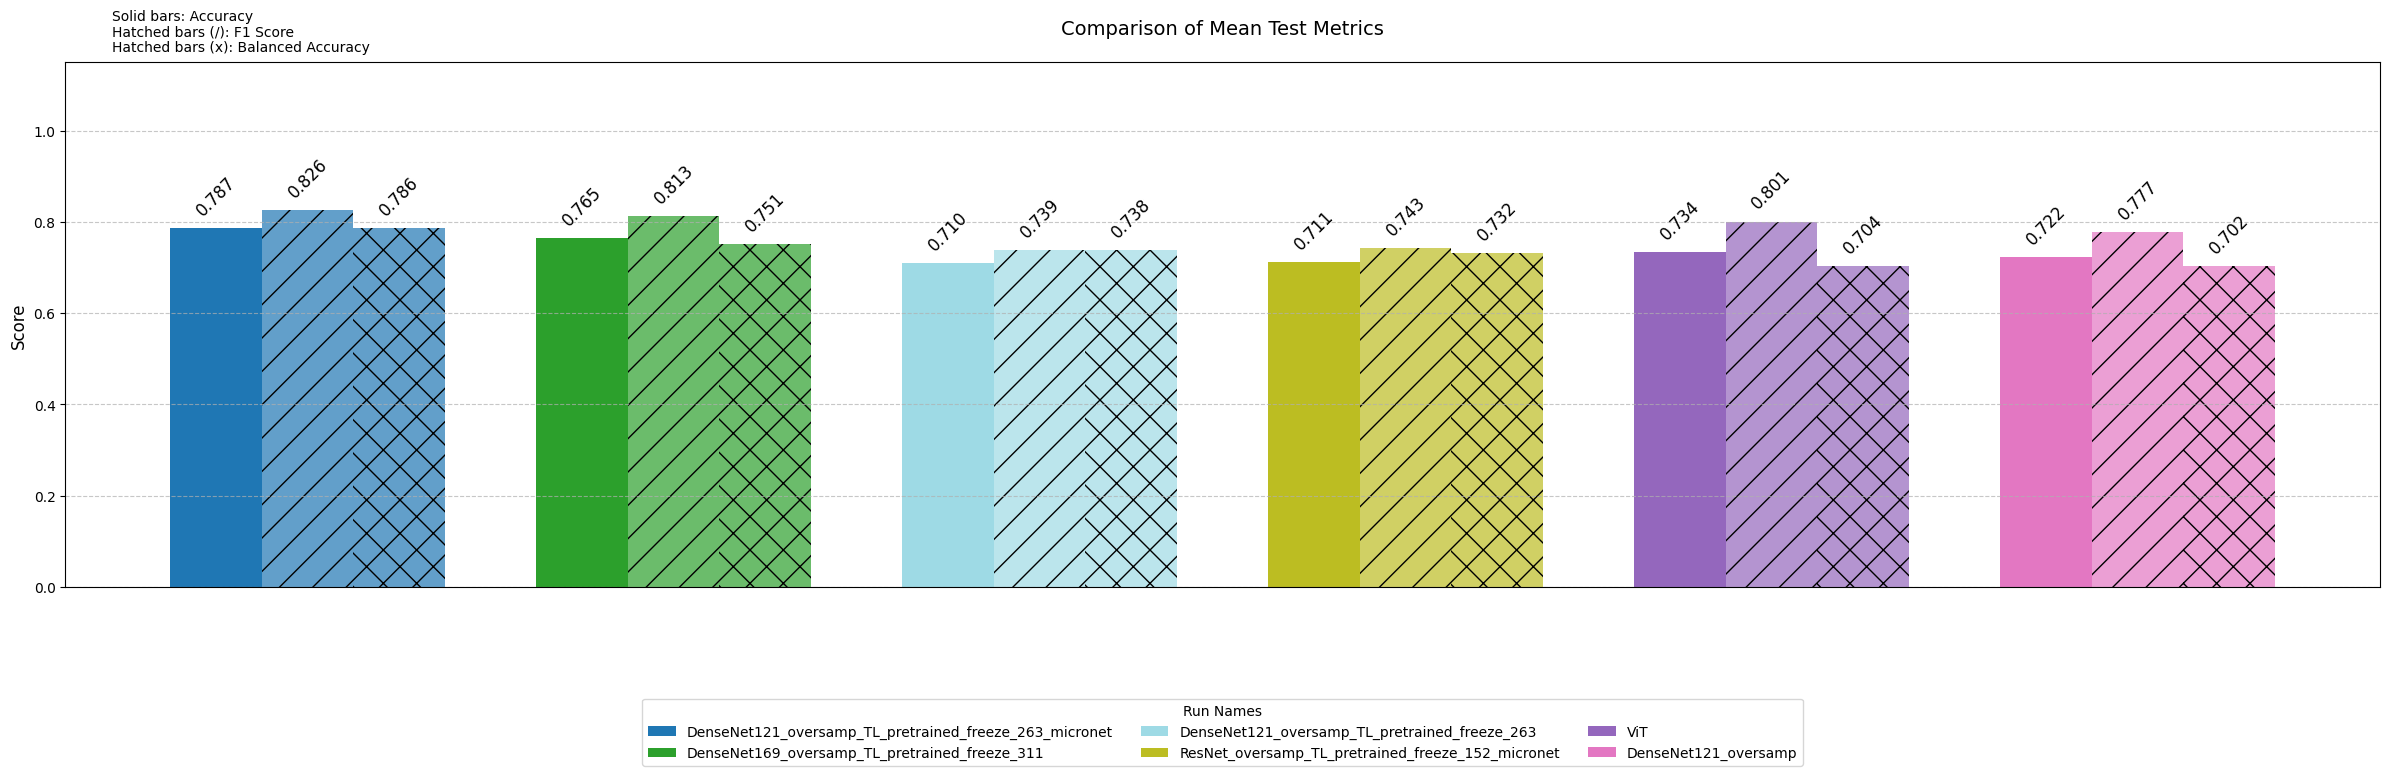

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the runs by balanced accuracy (from higher to lower)
sorted_run_color = sorted(
    run_color_map.items(),
    key=lambda item: combined_runs_df.loc[
        combined_runs_df['shortened_name'] == item[0], 'metrics.mean_test_balanced_accuracy'
    ].values[0],
    reverse=True
)

# Create positions for bars
x = np.arange(len(sorted_run_color))
width = 0.25  # Reduced width to accommodate third set of bars

plt.figure(figsize=(24, 8))

# First set of bars - Validation Accuracy
acc_containers = []
for i, (run_name, color) in enumerate(sorted_run_color):
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        x[i] - width,
        run_data['metrics.mean_test_accuracy'],
        width,
        color=color,
        label=run_name
    )
    acc_containers.append(container)

# Second set of bars - F1 Score
f1_containers = []
for i, (run_name, color) in enumerate(sorted_run_color):
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        x[i],
        run_data['metrics.mean_test_f1'],
        width,
        color=color,
        alpha=0.7,
        hatch='/'
    )
    f1_containers.append(container)

# Third set of bars - Balanced Accuracy
bal_acc_containers = []
for i, (run_name, color) in enumerate(sorted_run_color):
    run_data = combined_runs_df[combined_runs_df['shortened_name'] == run_name]
    container = plt.bar(
        x[i] + width,
        run_data['metrics.mean_test_balanced_accuracy'],
        width,
        color=color,
        alpha=0.7,
        hatch='x'
    )
    bal_acc_containers.append(container)

# Set x-axis ticks and labels
plt.xticks([])  # remove x ticks (or you can customize if needed)
plt.ylim(0, 1.15)
plt.title("Comparison of Mean Test Metrics", fontsize=14, pad=20)
plt.ylabel("Score", fontsize=12)

# Add value labels on top of each bar with alternating heights
for containers in [acc_containers, f1_containers, bal_acc_containers]:
    for container in containers:
        for idx, bar in enumerate(container):
            yval = bar.get_height()
            offset = 0.02 if idx % 2 == 0 else 0.04
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval + offset,
                f'{yval:.3f}',
                ha='center',
                va='bottom',
                rotation=45,
                fontsize=12
            )

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create legend for run names
plt.legend(title="Run Names", bbox_to_anchor=(0.5, -0.2),
           loc='upper center', ncol=3)

# Add metric type annotations
plt.text(0.02, 1.08, "Solid bars: Accuracy", transform=plt.gca().transAxes,
         fontsize=10, ha='left')
plt.text(0.02, 1.05, "Hatched bars (/): F1 Score", transform=plt.gca().transAxes,
         fontsize=10, ha='left')
plt.text(0.02, 1.02, "Hatched bars (x): Balanced Accuracy", transform=plt.gca().transAxes,
         fontsize=10, ha='left')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
metrics_of_interest = ["metrics.mean_test_accuracy", "metrics.mean_test_precision", "metrics.test_recall", "metrics.test_f1"]
combined_runs_df = combined_runs_df.dropna(subset=metrics_of_interest)
#combined_runs_df['shortened_name'] = combined_runs_df['tags.mlflow.runName'].str.replace('DenseNet_', '')
# 4) Create a "melted" DF to plot each test metric side by side
plot_df = combined_runs_df[["shortened_name"] + metrics_of_interest].copy()
plot_df = plot_df.melt(id_vars="shortened_name", var_name="metric", value_name="value")
# Set Seaborn style
sns.set_style("whitegrid")  # Use whitegrid style instead of plt.style.use
sns.set_palette("muted")  # Using a colorful palette
sns.set_context("talk")  # Larger context for better readability

# Create figure and axes
fig, ax = plt.subplots(figsize=(24, 10))

# Create the bar plot
sns.barplot(
    data=plot_df,
    x="shortened_name",
    y="value",
    hue="metric",
    dodge=True,
    width=0.8,
    ax=ax,
    capsize=0.05,  # Add small caps at the end of error bars
    errwidth=2,
    edgecolor='black',  # Add black edges to bars
    linewidth=1
)

# Customize the plot
ax.grid(True, linestyle='--', alpha=0.7, axis='y')
ax.set_ylim(0, 1.0)

# Customize labels and title
ax.set_title("Test Metrics Comparison", pad=20, fontsize=20, fontweight='bold')
ax.set_xlabel("Model Configuration", fontsize=14, labelpad=10)
ax.set_ylabel("Metric Value", fontsize=14, labelpad=10)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Customize legend
legend = ax.legend(
    title="Metrics",
    title_fontsize=14,
    fontsize=12,
    bbox_to_anchor=(1.02, 0.5),
    loc='center left',
    borderaxespad=0
)

# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f',
        padding=3,
        fontsize=10,
        fontweight='bold'
    )

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Optional: Save the plot with high DPI
 # plt.savefig('model_metrics_comparison.png', dpi=300, bbox_inches='tight')

KeyError: ['metrics.mean_test_precision', 'metrics.test_recall', 'metrics.test_f1']

In [ ]:
combined_runs_df

tags.mlflow.runName  metrics.mean_test_f1  \
5  DenseNet121_oversamp_TL_pretrained_freeze_263_...              0.825668   
3  DenseNet169_oversamp_TL_pretrained_freeze_311_...              0.812973   
0                               ViT_oversample_fixed              0.800577   
2              DenseNet121_oversamp_oversample_fixed              0.776848   
4  ResNet_oversamp_TL_pretrained_freeze_152_micro...              0.743056   
1  DenseNet121_oversamp_TL_pretrained_freeze_263_...              0.739041   

   metrics.mean_test_balanced_accuracy  metrics.mean_test_accuracy  \
5                             0.785606                    0.786806   
3                             0.751010                    0.764583   
0                             0.703788                    0.734028   
2                             0.702273                    0.722222   
4                             0.732323                    0.711111   
1                             0.737879                    0.710417   

                                      shortened_name  \
5  DenseNet121_oversamp_TL_pretrained_freeze_263_...   
3  DenseNet169_oversamp_TL_pretrained_freeze_311_...   
0                               ViT_oversample_fixed   
2              DenseNet121_oversamp_oversample_fixed   
4  ResNet_oversamp_TL_pretrained_freeze_152_micro...   
1  DenseNet121_oversamp_TL_pretrained_freeze_263_...   

                                               color  
5  [0.12156862745098039, 0.4666666666666667, 0.70...  
3  [0.17254901960784313, 0.6274509803921569, 0.17...  
0  [0.5803921568627451, 0.403921568627451, 0.7411...  
2  [0.8901960784313725, 0.4666666666666667, 0.760...  
4  [0.7372549019607844, 0.7411764705882353, 0.133...  
1  [0.6196078431372549, 0.8549019607843137, 0.898...